## GAN to balance the training data-set
## This notebook is to apply GAN on Scania Dataset with PCA (PCs=11), with different Imbalance Ratio

**Yasmin Fathy <Fathy.Yasmin@gmail.com>**

**Latest Updates: 30/08/2020**

In [1]:
import pandas as pd
import numpy as np
import os
from pprint import pprint

# to display fully (non-truncated) data-frame
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
#pd.set_option('display.max_colwidth', -1)

#Setup to show all results in jupiter not only the last one:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # revert to 'last_expr' to get only last results

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
from pprint import pprint

import matplotlib as mpl
#mpl.rcParams['figure.figsize'] = (20,20)
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

## Evaluation

In [2]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, precision_score, make_scorer,\
    recall_score, f1_score, precision_recall_curve, log_loss, cohen_kappa_score,roc_curve, auc
from tqdm import tqdm

In [3]:
RANDOM_STATE = 42

**APS Misclasification Cost Function**

In [4]:
def __perform_measure(y_actual, y_hat):
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        y_actual = list(y_actual)
        y_hat = list(y_hat)
        for i in range(len(y_hat)):
            if y_actual[i] == y_hat[i] == 1:
                TP += 1
            if y_hat[i] == 1 and y_actual[i] != y_hat[i]:
                FP += 1
            if y_actual[i] == y_hat[i] == 0:
                TN += 1
            if y_hat[i] == 0 and y_actual[i] != y_hat[i]:
                FN += 1

        return [TP, FP, TN, FN]

def custom_cost_fn_loss(y_actual, y_hat):
        [TP, FP, TN, FN] = __perform_measure(y_actual, y_hat)
        # print(len(list(y_actual)),
        #       len(list(y_hat)))
        # cm = confusion_matrix(list(y_actual), list(y_hat))
        # print(len(cm))
        # print(len(cm[0]))
        # print(cm)
        # FP = cm[0][1]
        # FN = cm[1][0]
        return (500 * FN) + (FP * 10)
    
APS_cost_fn = make_scorer(custom_cost_fn_loss, greater_is_better=False)

### ML Model Evalution

- **y** : original label in the testing-set
- **y_predict**: predicted label from the ML algorithm
- **y_predict_prob**: probability output of the algorithm about the minority class

**Plotting the precision, recall curve**

In [5]:
def plot_precession_recall_curve(y, y_predict, alg_name):
    fpr, tpr, thresholds = precision_recall_curve(y, y_predict)
    roc_auc = auc(fpr, tpr)


    plt.figure()
    plt.plot(fpr, tpr, color='red', label='Precision Recall curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Precision Recall curve  '+ str(alg_name))
    plt.legend(loc="lower right")
    plt.show();

In [6]:
def plot_roc_auc_curve(y, y_predict, alg_name):
    fpr, tpr, thresholds = roc_curve(y, y_predict)
    roc_auc = auc(fpr, tpr)


    plt.figure()
    plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show();

**Evaluating the results using a set of metrics**

In [7]:
def model_evaluaiton(y, y_predict, alg_name):        
            print(classification_report(y, list(y_predict)))
            cm = confusion_matrix(y, list(y_predict))
            print(cm)
            print("Accuracy:", accuracy_score(y, y_predict))
            print("roc_auc_score:", roc_auc_score(y, y_predict))
            print("precision_score:", precision_score(y, y_predict))
            print("recall_score:", recall_score(y, y_predict))
            print("f1_score:", f1_score(y, y_predict))
            FP = cm[0][1]
            FN = cm[1][0]
            print("CM: FP", FP)
            print("CM: FN", FN)
            print("APS Cost = ", (500 * FN) + (FP * 10))
            plot_precession_recall_curve(y, y_predict, alg_name)
            plot_roc_auc_curve(y, y_predict, alg_name)

**Finding the threshold that minimises the misclassification of the minority class i.e. class = 1 and apply the best threshold as post-processing steps**

In [8]:
def find_cut_off(y, y_predict_prob_maj):
    fpr, tpr, thresholds = precision_recall_curve(y, y_predict_prob_maj)
    min_cost = np.inf
    best_threshold = 0.5
    costs = []
    for threshold in tqdm(thresholds):
        #y_pred_threshold = np.where(scores > threshold, 0, 1)
        y_pred_threshold = y_predict_prob_maj > threshold
        tn, fp, fn, tp = confusion_matrix(y, y_pred_threshold).ravel()
        cost = 10*fp + 500*fn
        costs.append(cost)
        if cost < min_cost:
            min_cost = cost
            best_threshold = threshold
    print("Best threshold: {:.4f}".format(best_threshold))
    print("Min cost: {:.2f}".format(min_cost))
    return best_threshold
    

---

## Read training and testing files

**Get the minority class samples**

In [9]:
def get_minority(df_train):
    return df_train[df_train['class'] == 1]

In [10]:
data_dir ="ScaniaDataset/dimReduction/"
df_train = pd.read_csv(data_dir+"pca_aps_mean_failure_train_set.csv")
df_test =  pd.read_csv(data_dir+"pca_aps_mean_failure_test_set.csv")

data_dir ="ScaniaDataset/"
df_gan = pd.read_csv(data_dir+"GAN_Scania.csv")

df_orig_minority = get_minority(df_train)

# data_dir ="ScaniaDataset/imputation/"
# df_train = pd.read_csv(data_dir+"imp_aps_mean_failure_training_set.csv")
# df_test =  pd.read_csv(data_dir+"imp_aps_mean_failure_test_set.csv")

In [11]:
df_train[10:12]

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,class
10,0.138328,-0.330887,-0.156912,-0.012809,0.061510,-0.037770,-0.046260,0.00685,-0.024045,0.021380,-0.005061,0
11,0.023933,-0.149777,-0.167296,-0.038588,0.058541,-0.037378,0.065629,0.02009,0.042327,-0.035638,0.003502,0


In [12]:
df_train["class"].value_counts()

df_test["class"].value_counts()

0    59000
1     1000
Name: class, dtype: int64

0    15625
1      375
Name: class, dtype: int64

In [13]:
df_train.head()
df_test.head()

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,class
0,-0.357653,0.149168,0.785559,0.107379,-0.068720,-0.028512,0.128307,0.002902,-0.073669,0.079233,-0.019663,0
1,-0.009868,0.178451,-0.153641,-0.106095,0.115751,0.677376,0.038713,0.021226,0.052543,-0.016909,-0.012898,0
2,0.036263,-0.202770,-0.164386,-0.072079,0.131766,-0.043973,-0.051563,-0.000143,0.000497,-0.034116,-0.000904,0
3,0.207965,-0.419020,-0.145090,-0.048601,-0.000098,-0.007554,-0.008067,0.004260,0.006622,0.011792,-0.001259,0
4,-0.111736,0.259781,-0.174570,-0.061653,-0.000418,-0.020208,0.079826,-0.010607,0.004089,-0.047178,-0.014056,0


,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,class
0,0.161155,-0.296518,-0.147703,-0.064035,-0.017811,-0.017302,0.001606,0.008635,0.022569,0.004805,-0.000669,0
1,0.197147,-0.390714,-0.145632,-0.052749,-0.003007,-0.008112,-0.006774,0.005026,0.008747,0.010879,-0.000986,0
2,-0.271152,0.611412,-0.183003,-0.143001,-0.002290,-0.010953,0.107131,-0.045472,0.038387,-0.092350,0.044199,0
3,-0.134755,0.120177,-0.180050,-0.094396,0.112898,-0.045628,0.058169,0.005929,0.011544,-0.038997,-0.004686,0
4,0.171726,-0.324381,-0.146679,-0.064361,-0.004982,-0.002021,-0.007429,0.004521,0.007393,0.011175,-0.000230,0


----

### Use data generated by GAN to preserve different ratio between the majoirty and minority classes

In [14]:
from collections import Counter
from numpy import log
from imblearn.over_sampling import SMOTE 

Using TensorFlow backend.


**Using the Shannon entropy as a measure of balance**
- Where IR tends to be:
    - 0 when the data is highly imbalanced and 
    - 1 when the data is balanced.

- Inspired from: 
https://stats.stackexchange.com/questions/239973/a-general-measure-of-data-set-imbalance


In [15]:
def imbalance_ratio(seq):
    n = len(seq)
    classes = [(label,float(count)) for 
               label,count in Counter(seq).items()]
    #print(classes)
    k = len(classes)
    #print(k)
    #calculate shannon entropy
    H = -sum([ (count/n) * log((count/n)) 
              for label,count in classes]) 
    #print(H)
    # get imbalance ratio
    IR = H/log(k)
    print("Non-normliased = ", str(H))
    print("IR = ", str(IR))
    return IR # near 0: high imbalance, near 1: high balance

**Check if we have the same value report for Normalised Shannon Entropy that is calculated in paper "A methodology..." isn't normalised**
- It turns out the shannon value in their paper isn't normalised, check the example on the original data
- Original data has the following counts for each class
[(0, 59000.0), (1, 1000.0)]

In [16]:
log((1/60)) 

-4.0943445622221

In [17]:
#[(0, 59000.0), (1, 1000.0)]
-((1/60) * log((1/60)) + ((59/60) * log((59/60))))
-((1/60) * log((1/60)) + ((59/60) * log((59/60))))/log(2)

0.08476607571480994

0.1222915970693747

**Measure IR for the original data**

In [18]:
imbalance_ratio(df_train["class"])

Non-normliased =  0.08476607571480994
IR =  0.1222915970693747


0.1222915970693747

**To reproduce Case II Experiements:**
- sampling_strategy = 2/59 => IR = 0.2
- sampling_strategy = 5/59 => IR = 0.4
- sampling_strategy = 9/59, 10/59, 11/59 => IR = 0.6
- sampling_strategy = 18/59 => IR = 0.8
- sampling_strategy = 59/59 => IR = 1.0

**define a dataframe for each case**

- IR =  0.1222915970693747 (original case we already have its results)

Before OverSampling, counts of label '1': 1000 (1.6666666666666667%)
Before OverSampling, counts of label '0': 59000 (98.33333333333333%)

After OverSampling, counts of label '1': 2000 (3.278688524590164%)
After OverSampling, counts of label '0': 59000 (96.72131147540983%)



- IR =  0.20818094555717104

Before OverSampling, counts of label '1': 1000 (1.6666666666666667%)
Before OverSampling, counts of label '0': 59000 (98.33333333333333%)

After OverSampling, counts of label '1': 5000 (7.8125%)
After OverSampling, counts of label '0': 59000 (92.1875%)


- IR =  0.3955378064564774


Before OverSampling, counts of label '1': 1000 (1.6666666666666667%)
Before OverSampling, counts of label '0': 59000 (98.33333333333333%)

After OverSampling, counts of label '1': 10000 (14.492753623188406%)
After OverSampling, counts of label '0': 59000 (85.5072463768116%)




- IR =  0.596999516760455

Before OverSampling, counts of label '1': 1000 (1.6666666666666667%)
Before OverSampling, counts of label '0': 59000 (98.33333333333333%)

After OverSampling, counts of label '1': 18000 (23.376623376623375%)
After OverSampling, counts of label '0': 59000 (76.62337662337663%)



- IR =  0.7845191388986642


Before OverSampling, counts of label '1': 1000 (1.6666666666666667%)
Before OverSampling, counts of label '0': 59000 (98.33333333333333%)

After OverSampling, counts of label '1': 59000 (50.0%)
After OverSampling, counts of label '0': 59000 (50.0%)
IR =  1.0

In [19]:
#sample_strategies = [2, 5, 10, 18, 59]

In [20]:
x=imbalance_ratio(df_train['class'])

print("".join(["="]*20))
## create df for IR = 0.2
df_train_2 = pd.concat([df_train, df_gan[:1000]])
x=imbalance_ratio(df_train_2['class'])
c_0 = len(df_train_2[df_train_2["class"]==0])
c_1 = len(df_train_2[df_train_2["class"]==1])
print("After OverSampling, counts of label '0': {} ({}%)".format(c_0, (c_0/len(df_train_2))* 100))
print("After OverSampling, counts of label '1': {} ({}%)\n".format(c_1, (c_1/len(df_train_2))* 100))

print("".join(["="]*20))

## create df for IR = 0.4
df_train_5 = pd.concat([df_train, df_gan[1000:5000]])
x=imbalance_ratio(df_train_5['class'])
c_0 = len(df_train_5[df_train_5["class"]==0])
c_1 = len(df_train_5[df_train_5["class"]==1])
print("After OverSampling, counts of label '0': {} ({}%)".format(c_0, (c_0/len(df_train_5))* 100))
print("After OverSampling, counts of label '1': {} ({}%)\n".format(c_1, (c_1/len(df_train_5))* 100))
print("".join(["="]*20))

## create df for IR = 0.6
df_train_10 = pd.concat([df_train, df_gan[5000:14000]])
x=imbalance_ratio(df_train_10['class'])
c_0 = len(df_train_10[df_train_10["class"]==0])
c_1 = len(df_train_10[df_train_10["class"]==1])
print("After OverSampling, counts of label '0': {} ({}%)".format(c_0, (c_0/len(df_train_10))* 100))
print("After OverSampling, counts of label '1': {} ({}%)\n".format(c_1, (c_1/len(df_train_10))* 100))
print("".join(["="]*20))

## create df for IR = 0.8
df_train_18 = pd.concat([df_train, df_gan[14000:31000]])
x=imbalance_ratio(df_train_18['class'])
c_0 = len(df_train_18[df_train_18["class"]==0])
c_1 = len(df_train_18[df_train_18["class"]==1])
print("After OverSampling, counts of label '0': {} ({}%)".format(c_0, (c_0/len(df_train_18))* 100))
print("After OverSampling, counts of label '1': {} ({}%)\n".format(c_1, (c_1/len(df_train_18))* 100))
print("".join(["="]*20))

## create df for IR = 1.0
df_train_59 = pd.concat([df_train, df_gan])
x=imbalance_ratio(df_train_59['class'])

Non-normliased =  0.08476607571480994
IR =  0.1222915970693747
Non-normliased =  0.14430003545925657
IR =  0.20818094555717104
After OverSampling, counts of label '0': 59000 (96.72131147540983%)
After OverSampling, counts of label '1': 2000 (3.278688524590164%)

Non-normliased =  0.27416591535017265
IR =  0.3955378064564774
After OverSampling, counts of label '0': 59000 (92.1875%)
After OverSampling, counts of label '1': 5000 (7.8125%)

Non-normliased =  0.41380853183815924
IR =  0.596999516760455
After OverSampling, counts of label '0': 59000 (85.5072463768116%)
After OverSampling, counts of label '1': 10000 (14.492753623188406%)

Non-normliased =  0.5437872292229252
IR =  0.7845191388986642
After OverSampling, counts of label '0': 59000 (76.62337662337663%)
After OverSampling, counts of label '1': 18000 (23.376623376623375%)

Non-normliased =  0.6931471805599453
IR =  1.0


## Get difference between generated and original
**Note: SMOTE concatenates the newly generated samples to the end of the original input data and returns that as the output**
- ref: https://datascience.stackexchange.com/questions/12768/location-of-the-resampled-data-from-smote

In [21]:
# df_minroty: is the data samples of the minority class in the original data
# df_generated: is all data samples including synthetic generated minority class and original data samples

from scipy import stats
def get_ks_test(df_minroty, df_generated, return_generated_df = False):
    # get the generated samples from smote by getting the difference between original dataset in "df_train" and sampled dataset "df_generated"
    # (which contains/combines original and generated data)
    minority_generated = df_generated[~df_generated.apply(tuple,1).isin(df_train.apply(tuple,1))]
    no_cols = len(df_minroty.columns)-1
    for idx in range(0, no_cols):
        print(stats.ks_2samp(df_minroty.iloc[:,idx], 
                       minority_generated.iloc[:, idx]))
    if return_generated_df:
        return minority_generated
    

In [22]:
# minority_generated = df_train_5[~df_train_5.apply(tuple,1).isin(df_train.apply(tuple,1))]
# minority_generated = minority_generated.drop(['class'], axis=1)
# # minority_generated

# minority_original = df_minority.drop(['class'], axis=1)
# # minority_original

# minority_original.corrwith(minority_generated, axis=0)

In [23]:
# from scipy.stats import pearsonr
# corr, _ = pearsonr(minority_original, minority_generated)
# corr
# p = minority_generated.to_numpy()
# q = minority_original.to_numpy()

# BC=np.sum(np.sqrt(p*q))
# BC

In [24]:
get_ks_test(df_orig_minority, df_train_2)

Ks_2sampResult(statistic=0.847, pvalue=0.0)
Ks_2sampResult(statistic=0.656, pvalue=1.2110195357376333e-203)
Ks_2sampResult(statistic=0.944, pvalue=0.0)
Ks_2sampResult(statistic=0.852, pvalue=0.0)
Ks_2sampResult(statistic=0.491, pvalue=9.691515433227226e-110)
Ks_2sampResult(statistic=0.423, pvalue=1.3639763952989482e-80)
Ks_2sampResult(statistic=0.499, pvalue=1.65134576941857e-113)
Ks_2sampResult(statistic=0.407, pvalue=1.8582877929472538e-74)
Ks_2sampResult(statistic=0.439, pvalue=5.368503601575849e-87)
Ks_2sampResult(statistic=0.482, pvalue=1.3758331243978358e-105)
Ks_2sampResult(statistic=0.412, pvalue=2.404084289563744e-76)


In [25]:
get_ks_test(df_orig_minority, df_train_5)

Ks_2sampResult(statistic=0.8475, pvalue=0.0)
Ks_2sampResult(statistic=0.65625, pvalue=1.1091455962057521e-299)
Ks_2sampResult(statistic=0.9455, pvalue=0.0)
Ks_2sampResult(statistic=0.8625, pvalue=0.0)
Ks_2sampResult(statistic=0.4955, pvalue=4.966910825351443e-171)
Ks_2sampResult(statistic=0.425, pvalue=6.164881393898548e-126)
Ks_2sampResult(statistic=0.50075, pvalue=1.1526381534243045e-174)
Ks_2sampResult(statistic=0.402, pvalue=1.016410797710738e-112)
Ks_2sampResult(statistic=0.44475, pvalue=7.140551496239552e-138)
Ks_2sampResult(statistic=0.47125, pvalue=9.692346899197288e-155)
Ks_2sampResult(statistic=0.413, pvalue=5.991688427914645e-119)


In [26]:
get_ks_test(df_orig_minority, df_train_10)

Ks_2sampResult(statistic=0.8458888888888889, pvalue=0.0)
Ks_2sampResult(statistic=0.654, pvalue=0.0)
Ks_2sampResult(statistic=0.945, pvalue=0.0)
Ks_2sampResult(statistic=0.8634444444444445, pvalue=0.0)
Ks_2sampResult(statistic=0.49766666666666665, pvalue=4.878585012695998e-194)
Ks_2sampResult(statistic=0.425, pvalue=1.2619337828321919e-141)
Ks_2sampResult(statistic=0.5035555555555555, pvalue=1.1999021812249267e-198)
Ks_2sampResult(statistic=0.40444444444444444, pvalue=2.6871563842127426e-128)
Ks_2sampResult(statistic=0.44266666666666665, pvalue=1.3124116627523599e-153)
Ks_2sampResult(statistic=0.47455555555555556, pvalue=1.790989019193932e-176)
Ks_2sampResult(statistic=0.4098888888888889, pvalue=9.192217788684579e-132)


In [27]:
get_ks_test(df_orig_minority, df_train_18)

Ks_2sampResult(statistic=0.8465882352941176, pvalue=0.0)
Ks_2sampResult(statistic=0.6558823529411764, pvalue=0.0)
Ks_2sampResult(statistic=0.945, pvalue=0.0)
Ks_2sampResult(statistic=0.8641764705882353, pvalue=0.0)
Ks_2sampResult(statistic=0.49882352941176467, pvalue=1.5187562939463174e-204)
Ks_2sampResult(statistic=0.42605882352941177, pvalue=2.4489340152491113e-149)
Ks_2sampResult(statistic=0.5021764705882353, pvalue=2.6804384572042324e-207)
Ks_2sampResult(statistic=0.4053529411764706, pvalue=3.2442994492460555e-135)
Ks_2sampResult(statistic=0.4435882352941176, pvalue=7.646734170140142e-162)
Ks_2sampResult(statistic=0.47311764705882353, pvalue=4.755651514016567e-184)
Ks_2sampResult(statistic=0.4132941176470588, pvalue=1.5069971421450914e-140)


In [28]:
get_ks_test(df_orig_minority, df_train_59)

Ks_2sampResult(statistic=0.8460344827586207, pvalue=0.0)
Ks_2sampResult(statistic=0.6552241379310344, pvalue=0.0)
Ks_2sampResult(statistic=0.9452413793103448, pvalue=0.0)
Ks_2sampResult(statistic=0.8637068965517242, pvalue=0.0)
Ks_2sampResult(statistic=0.4984310344827586, pvalue=1.4853776793764136e-212)
Ks_2sampResult(statistic=0.42529310344827587, pvalue=7.2190151300706765e-155)
Ks_2sampResult(statistic=0.5026034482758621, pvalue=4.031479159003228e-216)
Ks_2sampResult(statistic=0.4058448275862069, pvalue=4.5767437904686654e-141)
Ks_2sampResult(statistic=0.4427931034482758, pvalue=7.708116745756523e-168)
Ks_2sampResult(statistic=0.47348275862068967, pvalue=7.516964631617175e-192)
Ks_2sampResult(statistic=0.41237931034482755, pvalue=1.2451153956792294e-145)


In [29]:
# df_2_generated = df_train_2[~df_train_2.apply(tuple,1).isin(df_train.apply(tuple,1))]
# len(df_2_generated)

**Prepare test dataset**

In [30]:
y_test = df_test['class']
X_test = df_test.drop(['class'], axis=1)

In [31]:
len(X_test)

16000

----

## ML Predictive models on the data with augmentation minotity samples generated from GAN
**LR, RF, XGBoost are trained and tested for each case mentioned above**

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.linear_model import LogisticRegression

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb


In [33]:
#scoring_fn = "f1_weighted"
scoring_fn = APS_cost_fn

**Prepare training dataset**

In [34]:
def get_train_data(df_t):
    y_train = df_t['class']
    X_train = df_t.drop(['class'], axis=1)
    return X_train, y_train
    

**Make prediction of best model given X_test**

In [35]:
def model_prediction(best_model, X_test):
    print("Best estimator: ", best_model.best_estimator_)
    # X = X.values.reshape(-1, 1)
    model_prediction = best_model.predict(X_test)
    model_prob_prediction = best_model.predict_proba(X_test) 
    return model_prediction, model_prob_prediction

### Logistic Regression: 

In [36]:
# y_train = df_train['class']
# X_train = df_train.drop(['class'], axis=1)

In [37]:
def lr_model(X_train, y_train):
    LR_hyperparameters = dict(C=[0.01, 1, 10, 100],
                             max_iter=[6000])  # hyperparameter options

    # # Best options obtained from running the params mentioned above
#     LR_hyperparameters = dict(C=[1], max_iter=[6000])  # hyperparameter options
    LR_clf = GridSearchCV(LogisticRegression(class_weight="balanced", random_state=RANDOM_STATE),
                               param_grid=LR_hyperparameters, cv=5,
                               verbose=2, scoring=scoring_fn, n_jobs=-1)

    LR_best_model = LR_clf.fit(X_train, y_train)
    return LR_best_model

### df_train_2 (i.e. IR = 0.2)

In [38]:
X_train_2, y_train_2 = get_train_data(df_train_2)
LR_best_model_2 = lr_model(X_train_2, y_train_2)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    5.6s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    6.2s finished


**Evaluating on Testing-set**

Best estimator:  LogisticRegression(C=100, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=6000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     15625
           1       0.24      0.98      0.39       375

    accuracy                           0.93     16000
   macro avg       0.62      0.95      0.68     16000
weighted avg       0.98      0.93      0.95     16000

[[14491  1134]
 [    9   366]]
Accuracy: 0.9285625
roc_auc_score: 0.951712
precision_score: 0.244
recall_score: 0.976
f1_score: 0.3904
CM: FP 1134
CM: FN 9
APS Cost =  15840


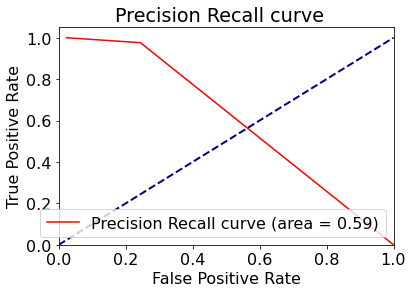

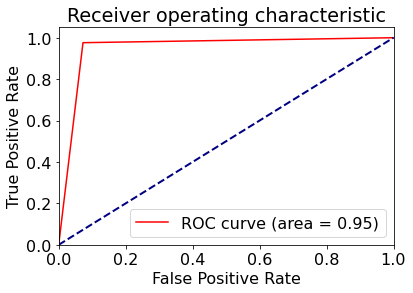

In [39]:
LR_model_pred_test_2, LR_model_prob_pred_test_2 = model_prediction(LR_best_model_2, X_test)
model_evaluaiton(y_test, LR_model_pred_test_2,"")

**Evaluate on Training-set**

Best estimator:  LogisticRegression(C=100, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=6000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96     59000
         1.0       0.26      0.77      0.39      2000

    accuracy                           0.92     61000
   macro avg       0.63      0.85      0.67     61000
weighted avg       0.97      0.92      0.94     61000

[[54666  4334]
 [  458  1542]]
Accuracy: 0.9214426229508197
roc_auc_score: 0.8487711864406781
precision_score: 0.2624234172906739
recall_score: 0.771
f1_score: 0.39156932453021837
CM: FP 4334
CM: FN 458
APS Cost =  272340


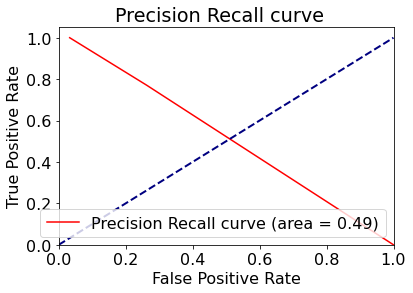

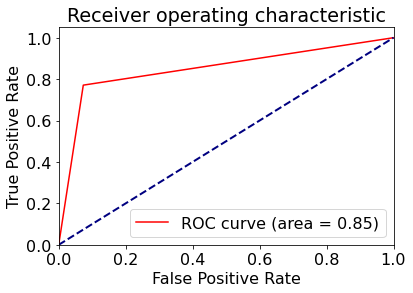

In [40]:
LR_model_pred_train_2, LR_model_prob_pred_train_2 = model_prediction(LR_best_model_2, X_train_2)
model_evaluaiton(y_train_2, LR_model_pred_train_2, "")

**Finding the threshold and then evaluate on testing data**
- LR_model_prob_pred_test_2[:,1] : classifier probability's output for minority class

In [41]:
LR_best_th_2 = find_cut_off(y_test, LR_model_prob_pred_test_2[:,1])

100%|██████████| 13141/13141 [12:44<00:00, 17.20it/s]

Best threshold: 0.5543
Min cost: 15090.00


In [42]:
LR_best_th_2

0.5542966613338326

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.27      0.97      0.42       375

    accuracy                           0.94     16000
   macro avg       0.63      0.95      0.69     16000
weighted avg       0.98      0.94      0.95     16000

[[14616  1009]
 [   10   365]]
Accuracy: 0.9363125
roc_auc_score: 0.9543786666666667
precision_score: 0.26564774381368267
recall_score: 0.9733333333333334
f1_score: 0.4173813607775872
CM: FP 1009
CM: FN 10
APS Cost =  15090


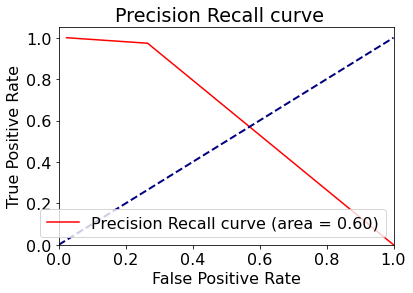

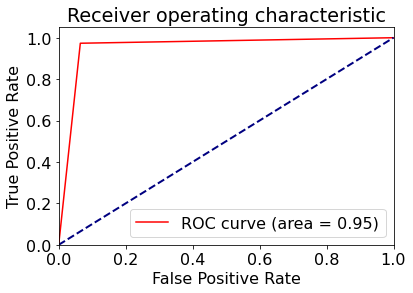

In [43]:
LR_predict_test_th_2 = LR_model_prob_pred_test_2[:,1] > LR_best_th_2
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, LR_predict_test_th_2, "")

**Just example to prove the point of how the threshold works**

In [44]:
(1.0-LR_best_th_2)
lr_th_2 = round((1.0-LR_best_th_2),3)
lr_th_2

0.4457033386661674

0.446

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.27      0.97      0.42       375

    accuracy                           0.94     16000
   macro avg       0.63      0.95      0.69     16000
weighted avg       0.98      0.94      0.95     16000

[[14614  1011]
 [   10   365]]
Accuracy: 0.9361875
roc_auc_score: 0.9543146666666666
precision_score: 0.26526162790697677
recall_score: 0.9733333333333334
f1_score: 0.4169046259280411
CM: FP 1011
CM: FN 10
APS Cost =  15110


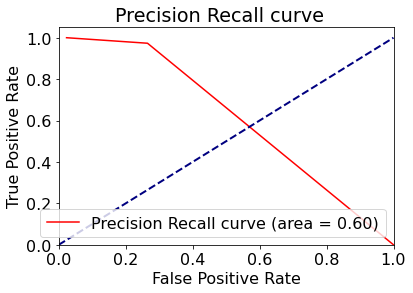

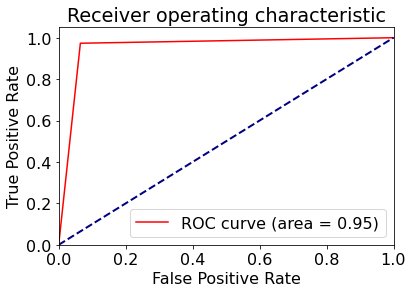

In [45]:
y_2 = LR_model_prob_pred_test_2[:,0] < lr_th_2
model_evaluaiton(y_test, y_2, "")

----

### Logistic Regression : df_train_5 (i.e. IR = 0.4)

In [46]:
X_train_5, y_train_5 = get_train_data(df_train_5)
LR_best_model_5 = lr_model(X_train_5, y_train_5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    3.8s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.5s finished


**Evaluating on Testing-set**

Best estimator:  LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=6000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     15625
           1       0.22      0.98      0.36       375

    accuracy                           0.92     16000
   macro avg       0.61      0.95      0.66     16000
weighted avg       0.98      0.92      0.94     16000

[[14326  1299]
 [    7   368]]
Accuracy: 0.918375
roc_auc_score: 0.9490986666666666
precision_score: 0.22075584883023394
recall_score: 0.9813333333333333
f1_score: 0.3604309500489716
CM: FP 1299
CM: FN 7
APS Cost =  16490


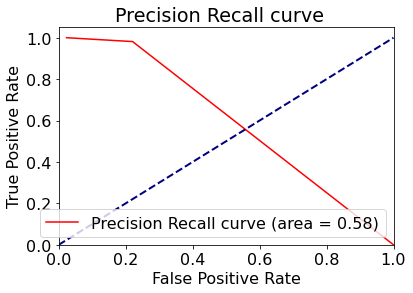

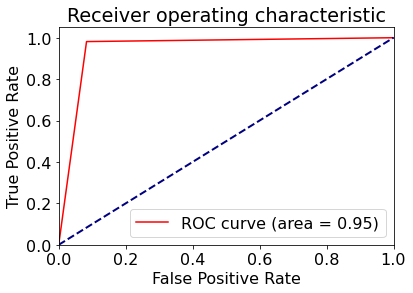

In [47]:
LR_model_pred_test_5, LR_model_prob_pred_test_5 = model_prediction(LR_best_model_5, X_test)
model_evaluaiton(y_test, LR_model_pred_test_5,"")

**Evaluate on Training-set**

Best estimator:  LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=6000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95     59000
         1.0       0.45      0.84      0.58      5000

    accuracy                           0.91     64000
   macro avg       0.72      0.88      0.77     64000
weighted avg       0.94      0.91      0.92     64000

[[53856  5144]
 [  812  4188]]
Accuracy: 0.9069375
roc_auc_score: 0.875206779661017
precision_score: 0.44877839691384486
recall_score: 0.8376
f1_score: 0.5844264582751884
CM: FP 5144
CM: FN 812
APS Cost =  457440


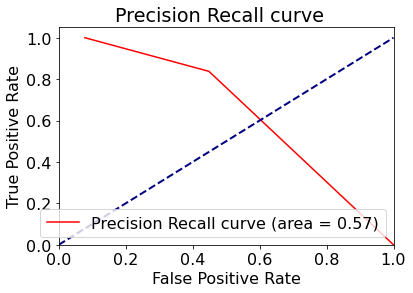

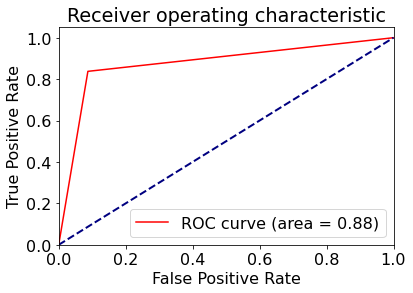

In [48]:
LR_model_pred_train_5, LR_model_prob_pred_train_5 = model_prediction(LR_best_model_5, X_train_5)
model_evaluaiton(y_train_5, LR_model_pred_train_5, "")

**Finding the threshold and then evaluate on testing data**
- LR_model_prob_pred_test_5[:,1] : classifier probability's output for minority class

In [49]:
LR_best_th_5 = find_cut_off(y_test, LR_model_prob_pred_test_5[:,1])

100%|██████████| 15778/15778 [15:13<00:00, 17.28it/s]

Best threshold: 0.6340
Min cost: 15390.00


In [50]:
LR_best_th_5

0.6340362364703724

              precision    recall  f1-score   support

           0       1.00      0.93      0.97     15625
           1       0.26      0.97      0.41       375

    accuracy                           0.93     16000
   macro avg       0.63      0.95      0.69     16000
weighted avg       0.98      0.93      0.95     16000

[[14586  1039]
 [   10   365]]
Accuracy: 0.9344375
roc_auc_score: 0.9534186666666666
precision_score: 0.25997150997151
recall_score: 0.9733333333333334
f1_score: 0.41034288926363127
CM: FP 1039
CM: FN 10
APS Cost =  15390


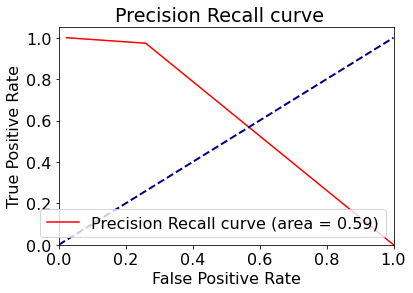

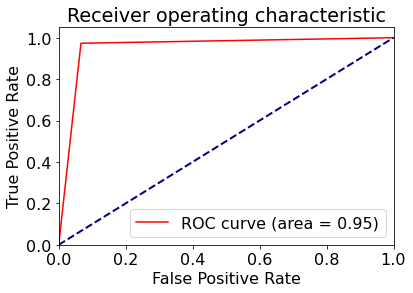

In [51]:
LR_predict_test_th_5 = LR_model_prob_pred_test_5[:,1] > LR_best_th_5
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, LR_predict_test_th_5, "")

**Just example to prove the point of how the threshold works**

In [52]:
(1.0-LR_best_th_5)
lr_th_5 = round((1.0-LR_best_th_5),3)
lr_th_5

0.36596376352962756

0.366

              precision    recall  f1-score   support

           0       1.00      0.93      0.97     15625
           1       0.26      0.97      0.41       375

    accuracy                           0.93     16000
   macro avg       0.63      0.95      0.69     16000
weighted avg       0.98      0.93      0.95     16000

[[14585  1040]
 [   10   365]]
Accuracy: 0.934375
roc_auc_score: 0.9533866666666667
precision_score: 0.2597864768683274
recall_score: 0.9733333333333334
f1_score: 0.4101123595505618
CM: FP 1040
CM: FN 10
APS Cost =  15400


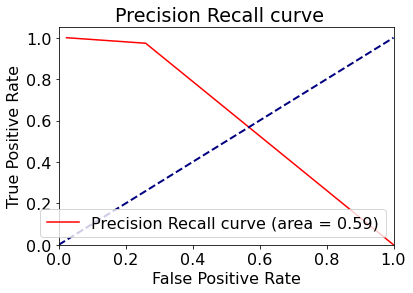

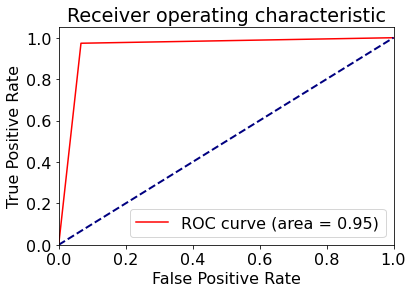

In [53]:
y_5 = LR_model_prob_pred_test_5[:,0] < lr_th_5
model_evaluaiton(y_test, y_5, "")

-----

### Logistic Regression : df_train_10 (i.e. IR = 0.6)

In [54]:
X_train_10, y_train_10 = get_train_data(df_train_10)
LR_best_model_10 = lr_model(X_train_10, y_train_10)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    3.9s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.7s finished


**Evaluating on Testing-set**

Best estimator:  LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=6000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     15625
           1       0.21      0.98      0.35       375

    accuracy                           0.91     16000
   macro avg       0.61      0.95      0.65     16000
weighted avg       0.98      0.91      0.94     16000

[[14260  1365]
 [    7   368]]
Accuracy: 0.91425
roc_auc_score: 0.9469866666666666
precision_score: 0.21234852856318523
recall_score: 0.9813333333333333
f1_score: 0.349146110056926
CM: FP 1365
CM: FN 7
APS Cost =  17150


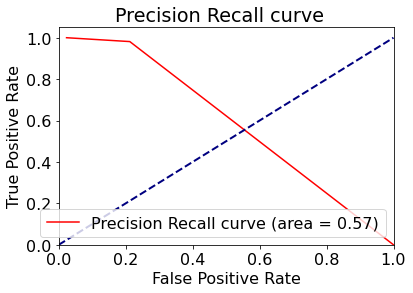

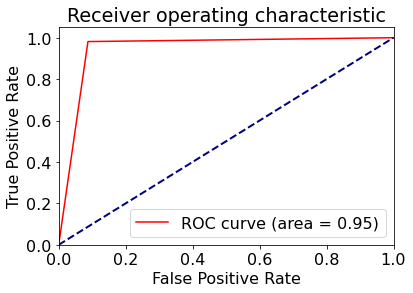

In [55]:
LR_model_pred_test_10, LR_model_prob_pred_test_10 = model_prediction(LR_best_model_10, X_test)
model_evaluaiton(y_test, LR_model_pred_test_10,"")

**Evaluate on Training-set**

Best estimator:  LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=6000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94     59000
         1.0       0.61      0.85      0.71     10000

    accuracy                           0.90     69000
   macro avg       0.79      0.88      0.83     69000
weighted avg       0.92      0.90      0.91     69000

[[53618  5382]
 [ 1457  8543]]
Accuracy: 0.9008840579710145
roc_auc_score: 0.8815398305084745
precision_score: 0.6135008976660682
recall_score: 0.8543
f1_score: 0.7141483803552768
CM: FP 5382
CM: FN 1457
APS Cost =  782320


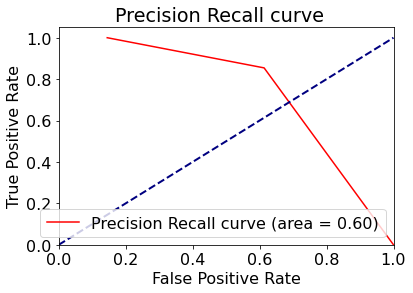

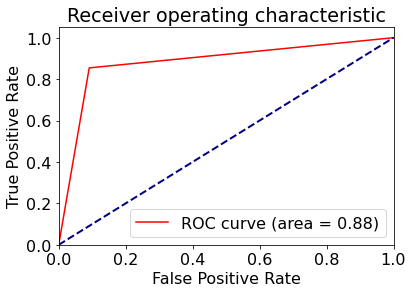

In [56]:
LR_model_pred_train_10, LR_model_prob_pred_train_10 = model_prediction(LR_best_model_10, X_train_10)
model_evaluaiton(y_train_10, LR_model_pred_train_10, "")

**Finding the threshold and then evaluate on testing data**
- LR_model_prob_pred_test_10[:,1] : classifier probability's output for minority class

In [57]:
LR_best_th_10 = find_cut_off(y_test, LR_model_prob_pred_test_10[:,1])

100%|██████████| 15885/15885 [13:24<00:00, 19.75it/s]

Best threshold: 0.6305
Min cost: 15350.00


In [58]:
LR_best_th_10

0.6304996824154122

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     15625
           1       0.25      0.98      0.40       375

    accuracy                           0.93     16000
   macro avg       0.63      0.95      0.68     16000
weighted avg       0.98      0.93      0.95     16000

[[14540  1085]
 [    9   366]]
Accuracy: 0.931625
roc_auc_score: 0.9532800000000001
precision_score: 0.25223983459682975
recall_score: 0.976
f1_score: 0.40087623220153334
CM: FP 1085
CM: FN 9
APS Cost =  15350


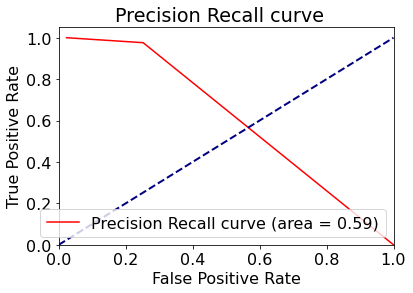

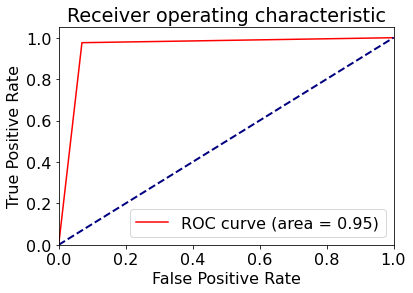

In [59]:
LR_predict_test_th_10 = LR_model_prob_pred_test_10[:,1] > LR_best_th_10
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, LR_predict_test_th_10, "")

**Just example to prove the point of how the threshold works**

In [60]:
(1.0-LR_best_th_10)
lr_th_3 = round((1.0-LR_best_th_10),3)
lr_th_3

0.3695003175845878

0.37

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     15625
           1       0.25      0.98      0.40       375

    accuracy                           0.93     16000
   macro avg       0.63      0.95      0.68     16000
weighted avg       0.98      0.93      0.95     16000

[[14539  1086]
 [    9   366]]
Accuracy: 0.9315625
roc_auc_score: 0.953248
precision_score: 0.25206611570247933
recall_score: 0.976
f1_score: 0.4006568144499179
CM: FP 1086
CM: FN 9
APS Cost =  15360


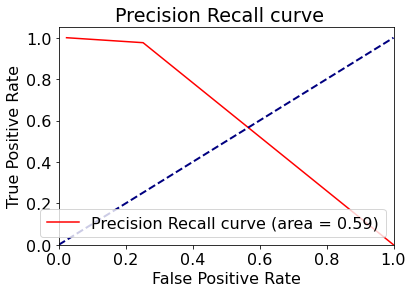

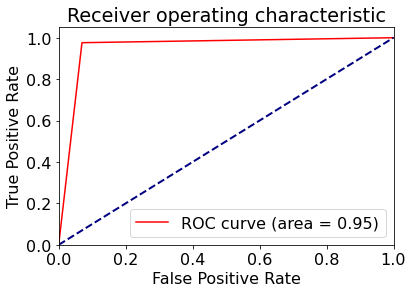

In [61]:
y_10 = LR_model_prob_pred_test_10[:,0] < lr_th_3
model_evaluaiton(y_test, y_10, "")

----

### Logistic Regression : df_train_18 (i.e. IR = 0.8)

In [62]:
X_train_18, y_train_18 = get_train_data(df_train_18)
LR_best_model_18 = lr_model(X_train_18, y_train_18)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    3.3s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.2s finished


**Evaluating on Testing-set**

Best estimator:  LogisticRegression(C=100, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=6000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     15625
           1       0.21      0.98      0.34       375

    accuracy                           0.91     16000
   macro avg       0.60      0.94      0.65     16000
weighted avg       0.98      0.91      0.94     16000

[[14222  1403]
 [    9   366]]
Accuracy: 0.91175
roc_auc_score: 0.9431039999999999
precision_score: 0.20689655172413793
recall_score: 0.976
f1_score: 0.3414179104477612
CM: FP 1403
CM: FN 9
APS Cost =  18530


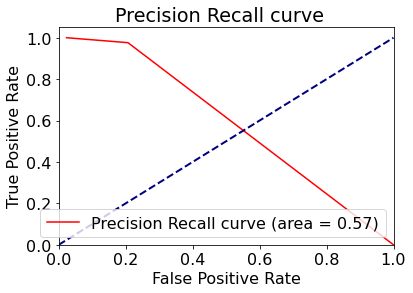

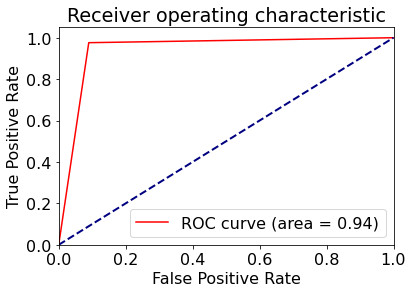

In [63]:
LR_model_pred_test_18, LR_model_prob_pred_test_18 = model_prediction(LR_best_model_18, X_test)
model_evaluaiton(y_test, LR_model_pred_test_18,"")

**Evaluate on Training-set**

Best estimator:  LogisticRegression(C=100, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=6000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

         0.0       0.96      0.91      0.93     59000
         1.0       0.74      0.87      0.80     18000

    accuracy                           0.90     77000
   macro avg       0.85      0.89      0.86     77000
weighted avg       0.91      0.90      0.90     77000

[[53463  5537]
 [ 2411 15589]]
Accuracy: 0.8967792207792208
roc_auc_score: 0.8861040489642185
precision_score: 0.7379058979456594
recall_score: 0.8660555555555556
f1_score: 0.7968614220722794
CM: FP 5537
CM: FN 2411
APS Cost =  1260870


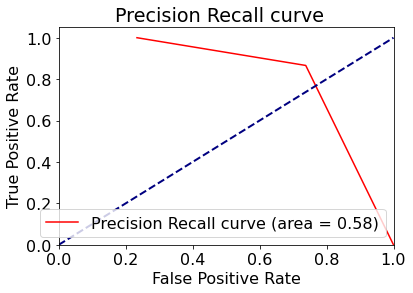

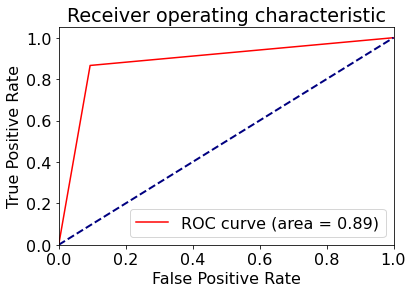

In [64]:
LR_model_pred_train_18, LR_model_prob_pred_train_18 = model_prediction(LR_best_model_18, X_train_18)
model_evaluaiton(y_train_18, LR_model_pred_train_18, "")

**Finding the threshold and then evaluate on testing data**
- LR_model_prob_pred_test_18[:, 1] : classifier probability's output for minority class

In [65]:
LR_best_th_18 = find_cut_off(y_test, LR_model_prob_pred_test_18[:,1])

100%|██████████| 15984/15984 [12:02<00:00, 22.12it/s]

Best threshold: 0.6086
Min cost: 16800.00


In [66]:
LR_best_th_18

0.6085725709292396

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     15625
           1       0.24      0.97      0.39       375

    accuracy                           0.93     16000
   macro avg       0.62      0.95      0.68     16000
weighted avg       0.98      0.93      0.95     16000

[[14495  1130]
 [   11   364]]
Accuracy: 0.9286875
roc_auc_score: 0.9491733333333334
precision_score: 0.24364123159303883
recall_score: 0.9706666666666667
f1_score: 0.3895131086142322
CM: FP 1130
CM: FN 11
APS Cost =  16800


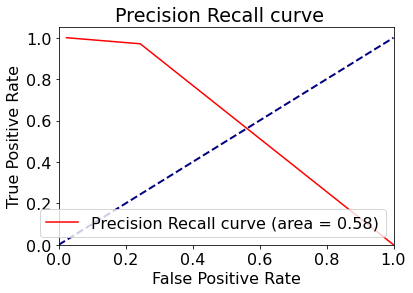

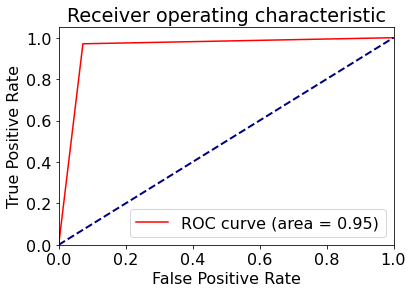

In [67]:
LR_predict_test_th_18 = LR_model_prob_pred_test_18[:,1] > LR_best_th_18
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, LR_predict_test_th_18, "")

**Just example to prove the point of how the threshold works**

In [68]:
(1.0-LR_best_th_18)
lr_th_18 = round((1.0-LR_best_th_18),3)
lr_th_18

0.39142742907076045

0.391

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     15625
           1       0.24      0.97      0.39       375

    accuracy                           0.93     16000
   macro avg       0.62      0.95      0.68     16000
weighted avg       0.98      0.93      0.95     16000

[[14495  1130]
 [   12   363]]
Accuracy: 0.928625
roc_auc_score: 0.94784
precision_score: 0.24313462826523777
recall_score: 0.968
f1_score: 0.38865096359743034
CM: FP 1130
CM: FN 12
APS Cost =  17300


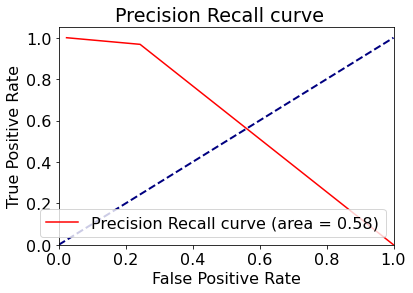

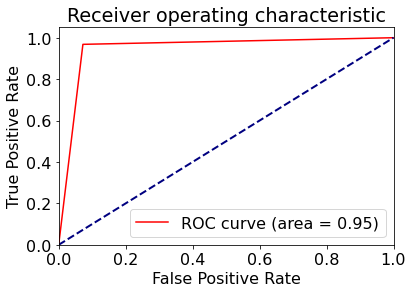

In [69]:
y_18 = LR_model_prob_pred_test_18[:,0] < lr_th_18
model_evaluaiton(y_test, y_18, "")

------

### Logistic Regression : df_train_59 (i.e. IR = 1.0)

In [70]:
X_train_59, y_train_59 = get_train_data(df_train_59)
LR_best_model_59 = lr_model(X_train_59, y_train_59)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    3.6s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.9s finished


**Evaluating on Testing-set**

Best estimator:  LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=6000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     15625
           1       0.19      0.98      0.32       375

    accuracy                           0.90     16000
   macro avg       0.59      0.94      0.63     16000
weighted avg       0.98      0.90      0.93     16000

[[14050  1575]
 [    7   368]]
Accuracy: 0.901125
roc_auc_score: 0.9402666666666666
precision_score: 0.1893978383942357
recall_score: 0.9813333333333333
f1_score: 0.3175150992234685
CM: FP 1575
CM: FN 7
APS Cost =  19250


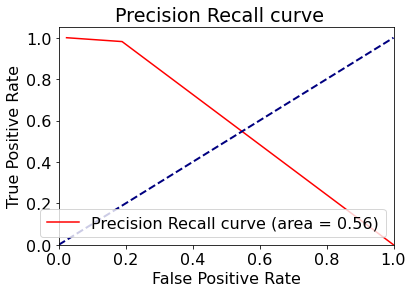

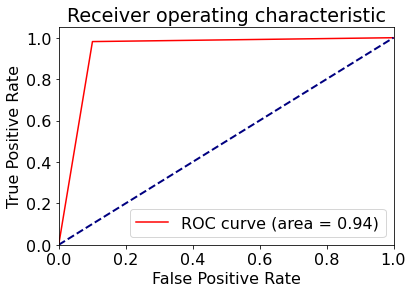

In [71]:
LR_model_pred_test_59, LR_model_prob_pred_test_59 = model_prediction(LR_best_model_59, X_test)
model_evaluaiton(y_test, LR_model_pred_test_59,"")

**Evaluate on Training-set**

Best estimator:  LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=6000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89     59000
         1.0       0.89      0.88      0.89     59000

    accuracy                           0.89    118000
   macro avg       0.89      0.89      0.89    118000
weighted avg       0.89      0.89      0.89    118000

[[52844  6156]
 [ 7152 51848]]
Accuracy: 0.8872203389830509
roc_auc_score: 0.8872203389830509
precision_score: 0.8938693883180471
recall_score: 0.8787796610169492
f1_score: 0.8862602987932037
CM: FP 6156
CM: FN 7152
APS Cost =  3637560


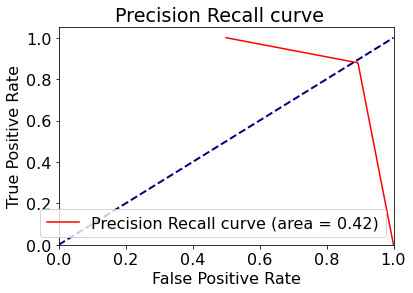

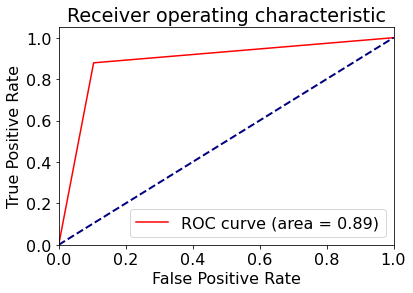

In [72]:
LR_model_pred_train_59, LR_model_prob_pred_train_59 = model_prediction(LR_best_model_59, X_train_59)
model_evaluaiton(y_train_59, LR_model_pred_train_59, "")

**Finding the threshold and then evaluate on testing data**
- LR_model_prob_pred_test_59[:,1] : classifier probability's output for minority class

In [73]:
LR_best_th_59 = find_cut_off(y_test, LR_model_prob_pred_test_59[:,1])

100%|██████████| 13790/13790 [09:01<00:00, 25.49it/s]

Best threshold: 0.6852
Min cost: 14400.00


In [74]:
LR_best_th_59

0.6851738172250754

              precision    recall  f1-score   support

           0       1.00      0.93      0.97     15625
           1       0.26      0.98      0.41       375

    accuracy                           0.93     16000
   macro avg       0.63      0.96      0.69     16000
weighted avg       0.98      0.93      0.95     16000

[[14585  1040]
 [    8   367]]
Accuracy: 0.9345
roc_auc_score: 0.9560533333333334
precision_score: 0.26083866382373844
recall_score: 0.9786666666666667
f1_score: 0.4118967452300785
CM: FP 1040
CM: FN 8
APS Cost =  14400


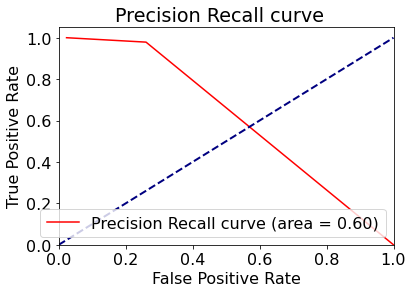

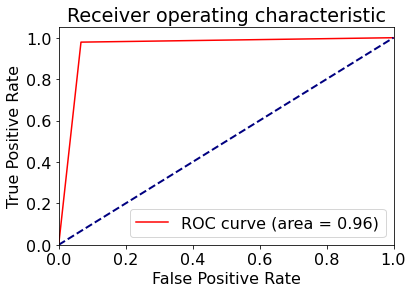

In [75]:
LR_predict_test_th_59 = LR_model_prob_pred_test_59[:,1] > LR_best_th_59
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, LR_predict_test_th_59, "")

**Just example to prove the point of how the threshold works**

In [76]:
(1.0-LR_best_th_59)
lr_th_59 = round((1.0-LR_best_th_59),3)
lr_th_59

0.3148261827749246

0.315

              precision    recall  f1-score   support

           0       1.00      0.93      0.97     15625
           1       0.26      0.98      0.41       375

    accuracy                           0.93     16000
   macro avg       0.63      0.96      0.69     16000
weighted avg       0.98      0.93      0.95     16000

[[14584  1041]
 [    8   367]]
Accuracy: 0.9344375
roc_auc_score: 0.9560213333333334
precision_score: 0.2606534090909091
recall_score: 0.9786666666666667
f1_score: 0.4116657319125071
CM: FP 1041
CM: FN 8
APS Cost =  14410


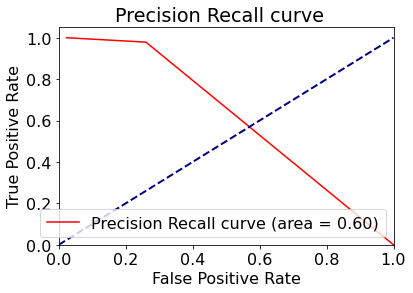

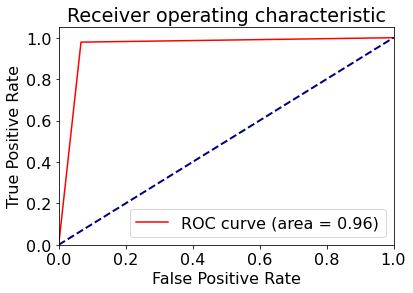

In [77]:
y_59 = LR_model_prob_pred_test_59[:,0] < lr_th_59
model_evaluaiton(y_test, y_59, "")

----

----

----

### Random Forest

In [78]:
def RF_model(X_train, y_train):
    RF_hyperparameters = {
                'n_estimators': [50, 100, 250],
#                 'max_features': ['auto', 'sqrt', 'log2'],
                # 'max_depth': [5, 6, 8, None],
                'max_depth': [5, 6, 8],
                'criterion': ['gini', 'entropy']}

    ## Best Params based on running the previous range of hyperparameter
#     RF_hyperparameters = {
#                           'n_estimators': [250],
#                            'max_depth': [5],
#                           'criterion': ['entropy']}
    RF_clf = GridSearchCV(RandomForestClassifier(class_weight="balanced", random_state= RANDOM_STATE),
                                   param_grid=RF_hyperparameters, cv=5,
                                   verbose=2, scoring=scoring_fn, n_jobs=-1)

    RF_best_model = RF_clf.fit(X_train, y_train)
    return RF_best_model

### df_train_2 (i.e. IR = 0.2)

In [79]:
X_train_2, y_train_2 = get_train_data(df_train_2)
RF_best_model_2 = RF_model(X_train_2, y_train_2)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  3.5min finished


**Evaluating on Testing-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.27      0.98      0.42       375

    accuracy                           0.94     16000
   macro avg       0.64      0.96      0.70     16000
weighted avg       0.98      0.94      0.95     16000

[[14642   983]
 [    9   366]]
Accuracy: 0.938
roc_auc_score: 0.956544
precision_score: 0.2713120830244626
re

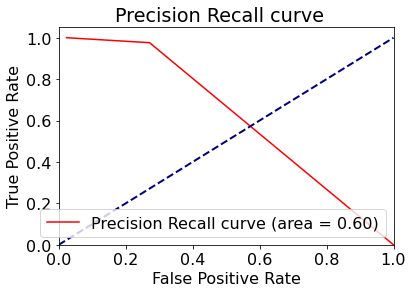

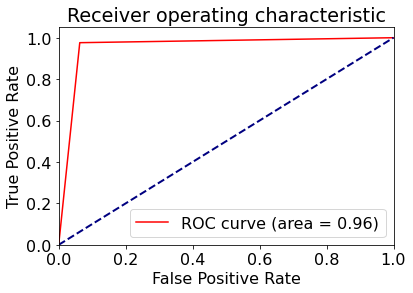

In [80]:
RF_model_pred_test_2, RF_model_prob_pred_test_2 = model_prediction(RF_best_model_2, X_test)
model_evaluaiton(y_test, RF_model_pred_test_2,"")

**Evaluate on Training-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97     59000
         1.0       0.34      0.98      0.51      2000

    accuracy                           0.94     61000
   macro avg       0.67      0.96      0.74     61000
weighted avg       0.98      0.94      0.95     61000

[[55253  3747]
 [   37  1963]]
Accuracy: 0.9379672131147541
roc_auc_score: 0.9589957627118644
precision_score

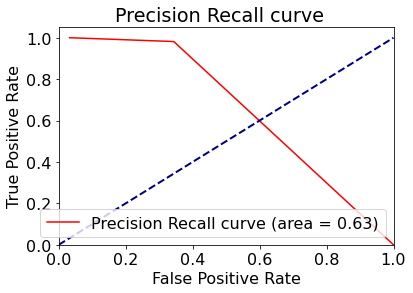

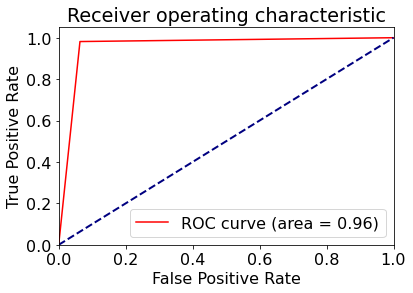

In [81]:
RF_model_pred_train_2, RF_model_prob_pred_train_2 = model_prediction(RF_best_model_2, X_train_2)
model_evaluaiton(y_train_2, RF_model_pred_train_2, "")

**Finding the threshold and then evaluate on testing data**
- RF_model_prob_pred_test_2[:,1] : classifier probability's output for minority class

In [82]:
RF_best_th_2 = find_cut_off(y_test, RF_model_prob_pred_test_2[:,1])

100%|██████████| 6002/6002 [03:44<00:00, 26.79it/s]

Best threshold: 0.4899
Min cost: 13900.00


In [83]:
RF_best_th_2

0.4898579253308892

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.27      0.98      0.42       375

    accuracy                           0.94     16000
   macro avg       0.63      0.96      0.70     16000
weighted avg       0.98      0.94      0.95     16000

[[14635   990]
 [    8   367]]
Accuracy: 0.937625
roc_auc_score: 0.9576533333333334
precision_score: 0.27044952100221076
recall_score: 0.9786666666666667
f1_score: 0.4237875288683603
CM: FP 990
CM: FN 8
APS Cost =  13900


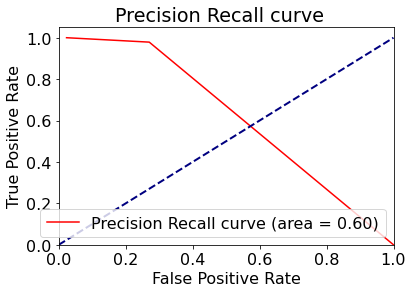

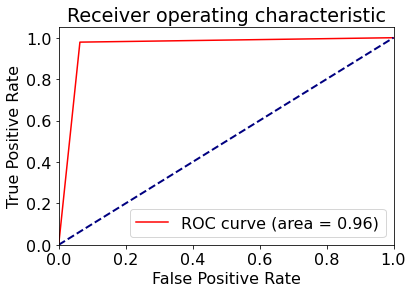

In [84]:
RF_predict_test_th_2 = RF_model_prob_pred_test_2[:,1] > RF_best_th_2
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, RF_predict_test_th_2, "")

**Just example to prove the point of how the threshold works**

In [85]:
(1.0-RF_best_th_2)
rf_th_2 = round((1.0-RF_best_th_2),3)
rf_th_2

0.5101420746691108

0.51

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.27      0.98      0.42       375

    accuracy                           0.94     16000
   macro avg       0.63      0.96      0.70     16000
weighted avg       0.98      0.94      0.95     16000

[[14635   990]
 [    8   367]]
Accuracy: 0.937625
roc_auc_score: 0.9576533333333334
precision_score: 0.27044952100221076
recall_score: 0.9786666666666667
f1_score: 0.4237875288683603
CM: FP 990
CM: FN 8
APS Cost =  13900


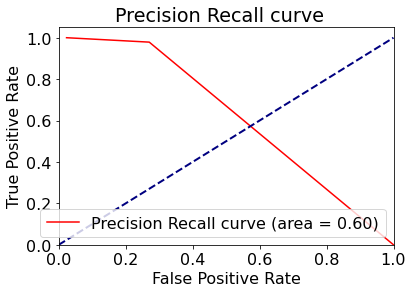

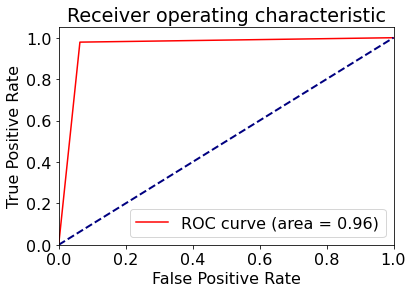

In [86]:
y_2 = RF_model_prob_pred_test_2[:,0] < rf_th_2
model_evaluaiton(y_test, y_2, "")

------

### df_train_5 (i.e. IR = 0.4)

In [87]:
X_train_5, y_train_5 = get_train_data(df_train_5)
RF_best_model_5 = RF_model(X_train_5, y_train_5)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  3.6min finished


**Evaluating on Testing-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     15625
           1       0.45      0.88      0.59       375

    accuracy                           0.97     16000
   macro avg       0.72      0.93      0.79     16000
weighted avg       0.98      0.97      0.98     16000

[[15214   411]
 [   44   331]]
Accuracy: 0.9715625
roc_auc_score: 0.9281813333333333
precision_score: 0.4

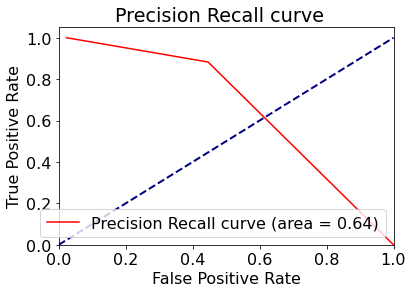

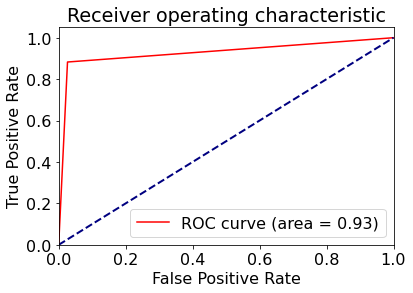

In [88]:
RF_model_pred_test_5, RF_model_prob_pred_test_5 = model_prediction(RF_best_model_5, X_test)
model_evaluaiton(y_test, RF_model_pred_test_5,"")

**Evaluate on Training-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99     59000
         1.0       0.76      0.98      0.86      5000

    accuracy                           0.97     64000
   macro avg       0.88      0.98      0.92     64000
weighted avg       0.98      0.97      0.98     64000

[[57456  1544]
 [   75  4925]]
Accuracy: 0.974703125
roc_auc_score: 0.9794152542372881
precision_score: 0

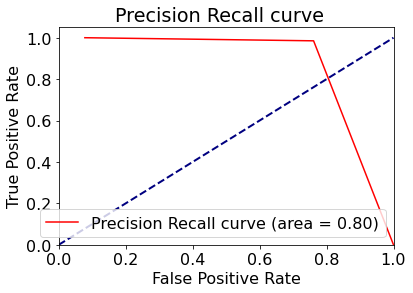

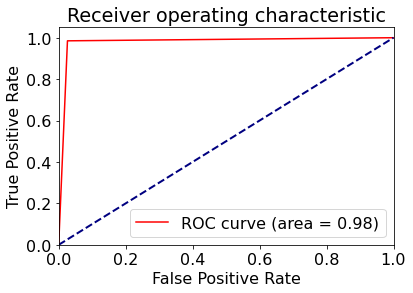

In [89]:
RF_model_pred_train_5, RF_model_prob_pred_train_5 = model_prediction(RF_best_model_5, X_train_5)
model_evaluaiton(y_train_5, RF_model_pred_train_5, "")

**Finding the threshold and then evaluate on testing data**
- RF_model_prob_pred_test_5[:,1] : classifier probability's output for minority class

In [90]:
RF_best_th_5 = find_cut_off(y_test, RF_model_prob_pred_test_5[:,1])

100%|██████████| 7278/7278 [05:46<00:00, 20.98it/s]

Best threshold: 0.1943
Min cost: 12680.00


In [91]:
RF_best_th_5

0.19425952874552282

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     15625
           1       0.31      0.98      0.47       375

    accuracy                           0.95     16000
   macro avg       0.65      0.96      0.72     16000
weighted avg       0.98      0.95      0.96     16000

[[14807   818]
 [    9   366]]
Accuracy: 0.9483125
roc_auc_score: 0.961824
precision_score: 0.3091216216216216
recall_score: 0.976
f1_score: 0.46953175112251444
CM: FP 818
CM: FN 9
APS Cost =  12680


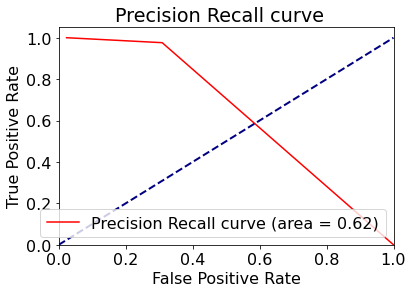

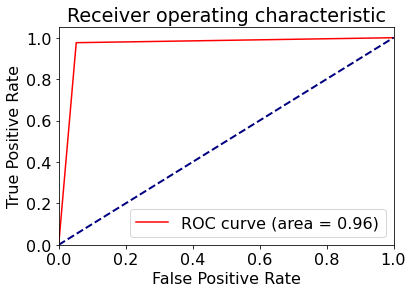

In [92]:
RF_predict_test_th_5 = RF_model_prob_pred_test_5[:,1] > RF_best_th_5
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, RF_predict_test_th_5, "")

**Just example to prove the point of how the threshold works**

In [93]:
(1.0-RF_best_th_5)
rf_th_5 = round((1.0-RF_best_th_5),3)
rf_th_5

0.8057404712544771

0.806

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     15625
           1       0.31      0.98      0.47       375

    accuracy                           0.95     16000
   macro avg       0.65      0.96      0.72     16000
weighted avg       0.98      0.95      0.96     16000

[[14806   819]
 [    9   366]]
Accuracy: 0.94825
roc_auc_score: 0.961792
precision_score: 0.30886075949367087
recall_score: 0.976
f1_score: 0.4692307692307693
CM: FP 819
CM: FN 9
APS Cost =  12690


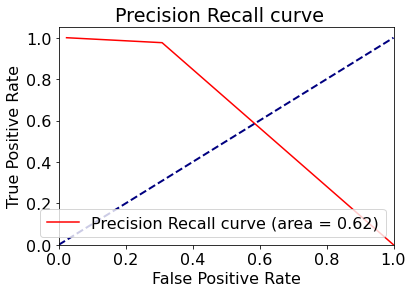

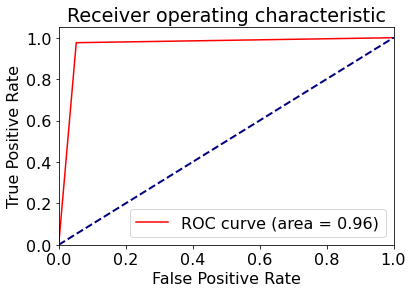

In [94]:
y_5 = RF_model_prob_pred_test_5[:,0] < rf_th_5
model_evaluaiton(y_test, y_5, "")

-----

### df_train_10 (i.e. IR = 0.6)

In [95]:
X_train_10, y_train_10 = get_train_data(df_train_10)
RF_best_model_10 = RF_model(X_train_10, y_train_10)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  4.4min finished


**Evaluating on Testing-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     15625
           1       0.49      0.82      0.62       375

    accuracy                           0.98     16000
   macro avg       0.74      0.90      0.80     16000
weighted avg       0.98      0.98      0.98     16000

[[15311   314]
 [   69   306]]
Accuracy: 0.9760625
roc_auc_score: 0.8979519999999999
precision_score: 0.4

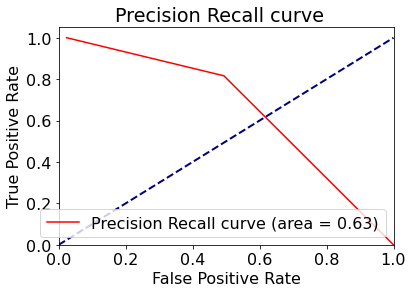

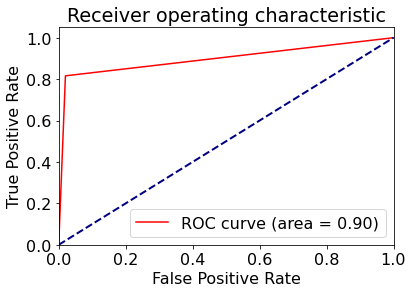

In [96]:
RF_model_pred_test_10, RF_model_prob_pred_test_10 = model_prediction(RF_best_model_10, X_test)
model_evaluaiton(y_test, RF_model_pred_test_10,"")

**Evaluate on Training-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     59000
         1.0       0.89      0.99      0.94     10000

    accuracy                           0.98     69000
   macro avg       0.94      0.98      0.96     69000
weighted avg       0.98      0.98      0.98     69000

[[57803  1197]
 [  118  9882]]
Accuracy: 0.9809420289855072
roc_auc_score: 0.9839559322033898
precision_s

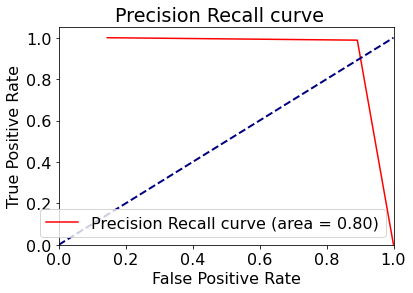

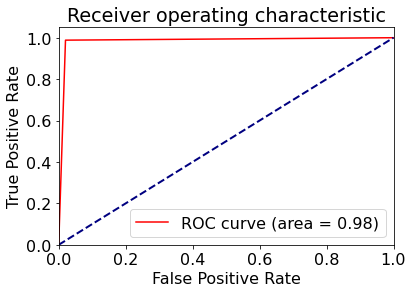

In [97]:
RF_model_pred_train_10, RF_model_prob_pred_train_10 = model_prediction(RF_best_model_10, X_train_10)
model_evaluaiton(y_train_10, RF_model_pred_train_10, "")

**Finding the threshold and then evaluate on testing data**
- RF_model_prob_pred_test_10[:,1] : classifier probability's output for minority class

In [98]:
RF_best_th_10 = find_cut_off(y_test, RF_model_prob_pred_test_10[:,1])

100%|██████████| 9237/9237 [06:39<00:00, 23.13it/s]

Best threshold: 0.1019
Min cost: 12520.00


In [99]:
RF_best_th_10

0.10194814208093038

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.28      0.98      0.44       375

    accuracy                           0.94     16000
   macro avg       0.64      0.96      0.70     16000
weighted avg       0.98      0.94      0.96     16000

[[14673   952]
 [    6   369]]
Accuracy: 0.940125
roc_auc_score: 0.9615360000000001
precision_score: 0.279333838001514
recall_score: 0.984
f1_score: 0.43514150943396224
CM: FP 952
CM: FN 6
APS Cost =  12520


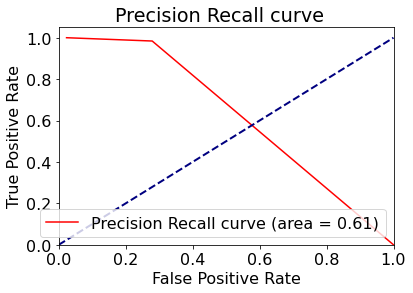

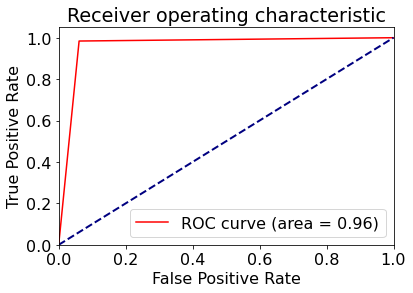

In [100]:
RF_predict_test_th_10 = RF_model_prob_pred_test_10[:,1] > RF_best_th_10
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, RF_predict_test_th_10, "")

**Just example to prove the point of how the threshold works**

In [101]:
(1.0-RF_best_th_10)
rf_th_10 = round((1.0-RF_best_th_10),3)
rf_th_10

0.8980518579190696

0.898

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.28      0.98      0.44       375

    accuracy                           0.94     16000
   macro avg       0.64      0.96      0.70     16000
weighted avg       0.98      0.94      0.96     16000

[[14673   952]
 [    6   369]]
Accuracy: 0.940125
roc_auc_score: 0.9615360000000001
precision_score: 0.279333838001514
recall_score: 0.984
f1_score: 0.43514150943396224
CM: FP 952
CM: FN 6
APS Cost =  12520


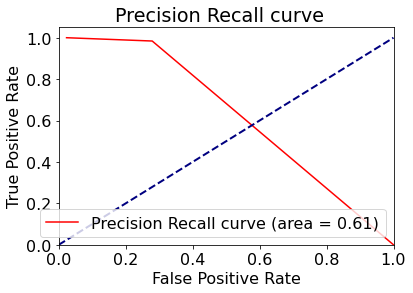

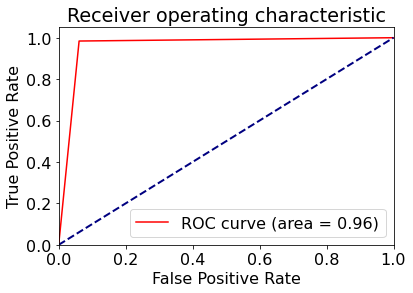

In [102]:
y_10 = RF_model_prob_pred_test_10[:,0] < rf_th_10
model_evaluaiton(y_test, y_10, "")

---

### df_train_18 (i.e. IR = 0.8)

In [103]:
X_train_18, y_train_18 = get_train_data(df_train_18)
RF_best_model_18 = RF_model(X_train_18, y_train_18)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  5.2min finished


**Evaluating on Testing-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     15625
           1       0.52      0.70      0.60       375

    accuracy                           0.98     16000
   macro avg       0.76      0.84      0.79     16000
weighted avg       0.98      0.98      0.98     16000

[[15385   240]
 [  112   263]]
Accuracy: 0.978
roc_auc_score: 0.8429866666666667
precision_score: 0.52286

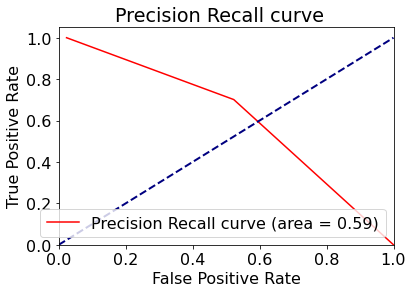

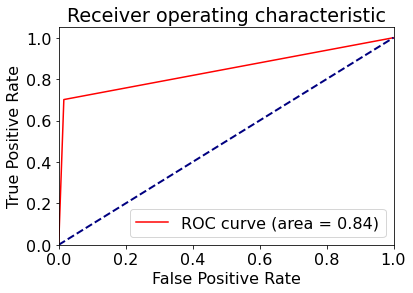

In [104]:
RF_model_pred_test_18, RF_model_prob_pred_test_18 = model_prediction(RF_best_model_18, X_test)
model_evaluaiton(y_test, RF_model_pred_test_18,"")

**Evaluate on Training-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     59000
         1.0       0.95      0.99      0.97     18000

    accuracy                           0.99     77000
   macro avg       0.98      0.99      0.98     77000
weighted avg       0.99      0.99      0.99     77000

[[58157   843]
 [  191 17809]]
Accuracy: 0.9865714285714285
roc_auc_score: 0.9875503766478343
precision_s

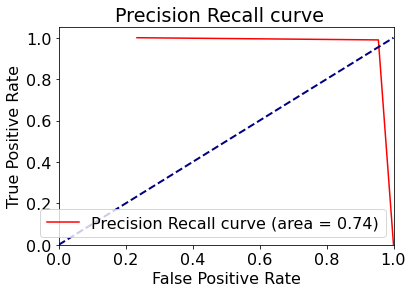

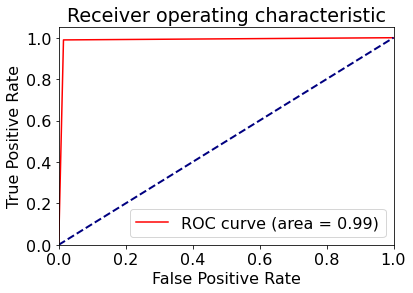

In [105]:
RF_model_pred_train_18, RF_model_prob_pred_train_18 = model_prediction(RF_best_model_18, X_train_18)
model_evaluaiton(y_train_18, RF_model_pred_train_18, "")

**Finding the threshold and then evaluate on testing data**
- RF_model_prob_pred_test_18[:,1] : classifier probability's output for minority class

In [106]:
RF_best_th_18 = find_cut_off(y_test, RF_model_prob_pred_test_18[:,1])

100%|██████████| 9556/9556 [07:13<00:00, 22.04it/s]

Best threshold: 0.0673
Min cost: 12920.00


In [107]:
RF_best_th_18

0.06728698057434108

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.27      0.98      0.43       375

    accuracy                           0.94     16000
   macro avg       0.64      0.96      0.70     16000
weighted avg       0.98      0.94      0.95     16000

[[14633   992]
 [    6   369]]
Accuracy: 0.937625
roc_auc_score: 0.960256
precision_score: 0.27112417340191036
recall_score: 0.984
f1_score: 0.42511520737327185
CM: FP 992
CM: FN 6
APS Cost =  12920


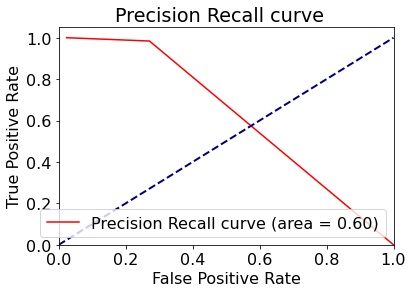

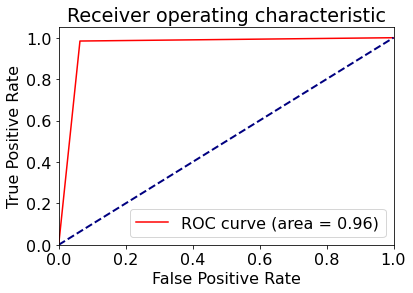

In [108]:
RF_predict_test_th_18 = RF_model_prob_pred_test_18[:,1] > RF_best_th_18
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, RF_predict_test_th_18, "")

**Just example to prove the point of how the threshold works**

In [109]:
(1.0-RF_best_th_18)
rf_th_18 = round((1.0-RF_best_th_18),3)
rf_th_18

0.9327130194256589

0.933

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.27      0.98      0.42       375

    accuracy                           0.94     16000
   macro avg       0.63      0.96      0.70     16000
weighted avg       0.98      0.94      0.95     16000

[[14626   999]
 [    6   369]]
Accuracy: 0.9371875
roc_auc_score: 0.960032
precision_score: 0.26973684210526316
recall_score: 0.984
f1_score: 0.42340791738382094
CM: FP 999
CM: FN 6
APS Cost =  12990


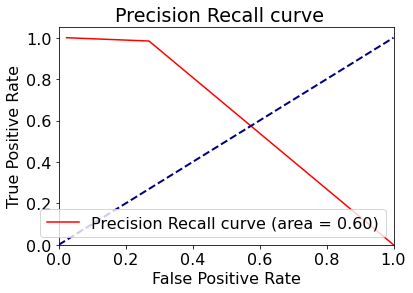

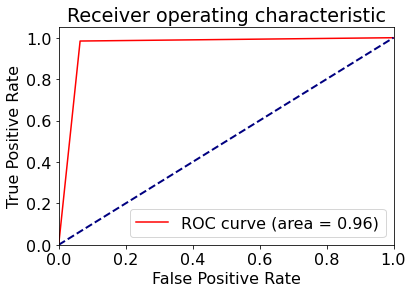

In [110]:
y_18 = RF_model_prob_pred_test_18[:,0] < rf_th_18
model_evaluaiton(y_test, y_18, "")

----

### df_train_59 (i.e. IR = 1.0)

In [111]:
X_train_59, y_train_59 = get_train_data(df_train_59)
RF_best_model_59 = RF_model(X_train_59, y_train_59)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  8.2min finished


**Evaluating on Testing-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     15625
           1       0.30      0.10      0.15       375

    accuracy                           0.97     16000
   macro avg       0.64      0.55      0.57     16000
weighted avg       0.96      0.97      0.97     16000

[[15538    87]
 [  337    38]]
Accuracy: 0.9735
roc_auc_score: 0.5478826666666666
precision_score: 0.304


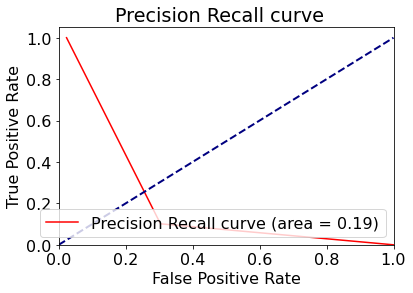

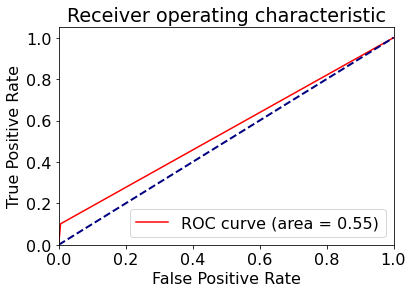

In [112]:
RF_model_pred_test_59, RF_model_prob_pred_test_59 = model_prediction(RF_best_model_59, X_test)
model_evaluaiton(y_test, RF_model_pred_test_59,"")

**Evaluate on Training-set**

Best estimator:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     59000
         1.0       1.00      0.99      0.99     59000

    accuracy                           0.99    118000
   macro avg       0.99      0.99      0.99    118000
weighted avg       0.99      0.99      0.99    118000

[[58720   280]
 [  868 58132]]
Accuracy: 0.990271186440678
roc_auc_score: 0.9902711864406779
precision_sc

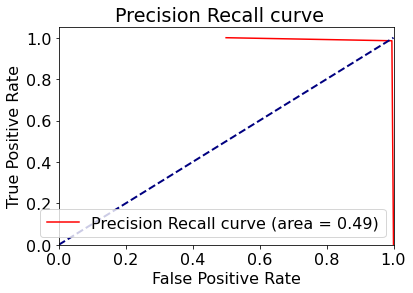

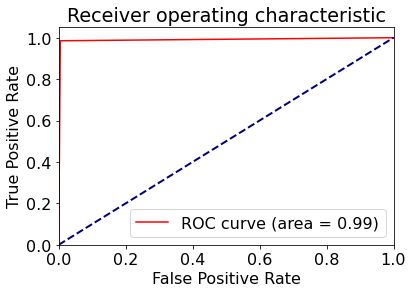

In [113]:
RF_model_pred_train_59, RF_model_prob_pred_train_59 = model_prediction(RF_best_model_59, X_train_59)
model_evaluaiton(y_train_59, RF_model_pred_train_59, "")

**Finding the threshold and then evaluate on testing data**
- RF_model_prob_pred_test_59[:,1] : classifier probability's output for minority class

In [114]:
RF_best_th_59 = find_cut_off(y_test, RF_model_prob_pred_test_59[:,1])

100%|██████████| 10256/10256 [06:56<00:00, 24.62it/s]

Best threshold: 0.0649
Min cost: 17210.00


In [115]:
RF_best_th_59

0.06485591138309076

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.27      0.96      0.42       375

    accuracy                           0.94     16000
   macro avg       0.63      0.95      0.69     16000
weighted avg       0.98      0.94      0.95     16000

[[14654   971]
 [   15   360]]
Accuracy: 0.938375
roc_auc_score: 0.948928
precision_score: 0.270473328324568
recall_score: 0.96
f1_score: 0.42203985932004695
CM: FP 971
CM: FN 15
APS Cost =  17210


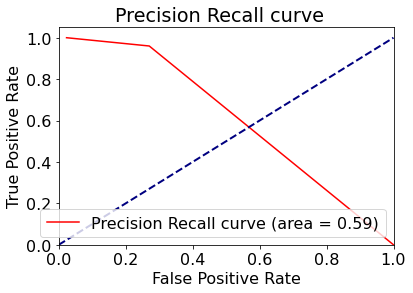

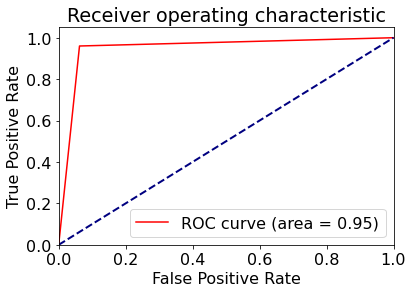

In [116]:
RF_predict_test_th_59 = RF_model_prob_pred_test_59[:,1] > RF_best_th_59
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, RF_predict_test_th_59, "")

**Just example to prove the point of how the threshold works**

In [117]:
(1.0-RF_best_th_59)
rf_th_59 = round((1.0-RF_best_th_59),3)
rf_th_59

0.9351440886169092

0.935

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.27      0.96      0.42       375

    accuracy                           0.94     16000
   macro avg       0.63      0.95      0.69     16000
weighted avg       0.98      0.94      0.95     16000

[[14654   971]
 [   15   360]]
Accuracy: 0.938375
roc_auc_score: 0.948928
precision_score: 0.270473328324568
recall_score: 0.96
f1_score: 0.42203985932004695
CM: FP 971
CM: FN 15
APS Cost =  17210


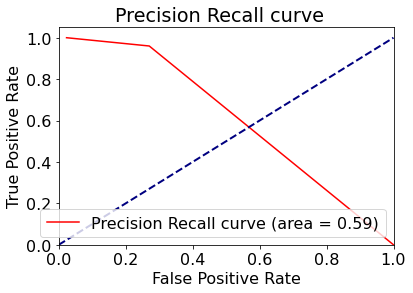

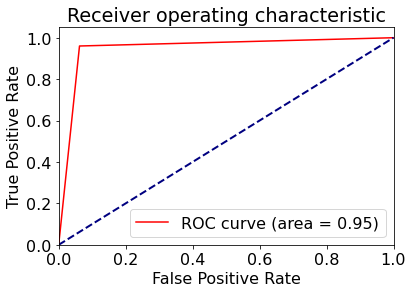

In [118]:
y_59 = RF_model_prob_pred_test_59[:,0] < rf_th_59
model_evaluaiton(y_test, y_59, "")

----

## XGBoost

In [119]:
def xgb_model(X_train, y_train):
    xg_hyperparameters = {
                    'max_depth': [3, 4, 5],
                    'n_estimators': [50, 100],
                    'learning_rate': [0.1, 0.01, 0.05]
                }

    # best param when PCA is used
#     xg_hyperparameters = {
#                     'max_depth': [5],
#                     'n_estimators': [100],
#                     'learning_rate': [0.1]
#                 }
    xg_clf = GridSearchCV(estimator=xgb.XGBClassifier(random_state=RANDOM_STATE),
                                   param_grid=xg_hyperparameters, cv=5,
                                   scoring=scoring_fn, n_jobs=-1,verbose=2)
    
    xgbb_best_model = xg_clf.fit(X_train, y_train)
    return xgbb_best_model

### df_train_2 (i.e. IR = 0.2)

In [120]:
X_train_2, y_train_2 = get_train_data(df_train_2)
xgb_best_model_2 = xgb_model(X_train_2, y_train_2)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.9min finished


**Evaluating on Testing-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15625
           1       0.73      0.42      0.53       375

    accuracy                           0.98     16000
   macro avg       0.86      0.71      0.76     16000
weighted avg       0.98      0.98      0.98     16000

[[15568    57]
 [  219   156]]
Accuracy

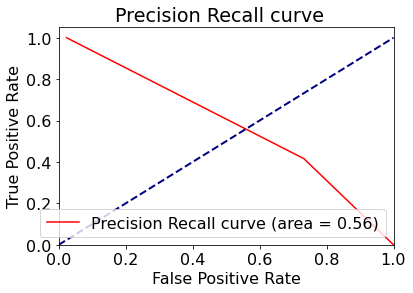

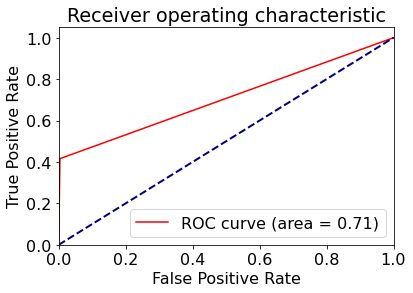

In [121]:
xgb_model_pred_test_2, xgb_model_prob_pred_test_2 = model_prediction(xgb_best_model_2, X_test)
model_evaluaiton(y_test, xgb_model_pred_test_2,"")

**Evaluate on Training-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     59000
         1.0       0.94      0.78      0.85      2000

    accuracy                           0.99     61000
   macro avg       0.97      0.89      0.92     61000
weighted avg       0.99      0.99      0.99     61000

[[58909    91]
 [  449  1551]]
Accuracy

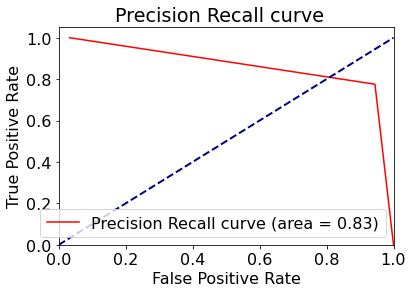

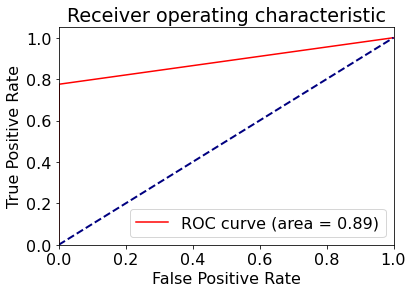

In [122]:
xgb_model_pred_train_2, xgb_model_prob_pred_train_2 = model_prediction(xgb_best_model_2, X_train_2)
model_evaluaiton(y_train_2, xgb_model_pred_train_2, "")

**Finding the threshold and then evaluate on testing data**
- xgb_model_prob_pred_test_2[:,1] : classifier probability's output for minority class

In [123]:
xgb_best_th_2 = find_cut_off(y_test, xgb_model_prob_pred_test_2[:,1])

100%|██████████| 7686/7686 [05:30<00:00, 23.27it/s]

Best threshold: 0.0180
Min cost: 12900.00


In [124]:
xgb_best_th_2

0.017977538

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.28      0.98      0.44       375

    accuracy                           0.94     16000
   macro avg       0.64      0.96      0.70     16000
weighted avg       0.98      0.94      0.96     16000

[[14685   940]
 [    7   368]]
Accuracy: 0.9408125
roc_auc_score: 0.9605866666666666
precision_score: 0.28134556574923547
recall_score: 0.9813333333333333
f1_score: 0.43731431966726086
CM: FP 940
CM: FN 7
APS Cost =  12900


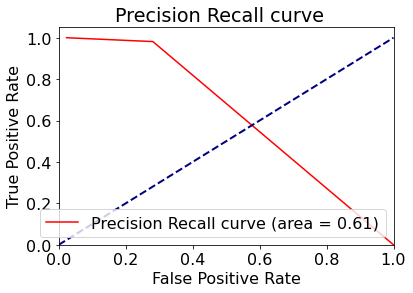

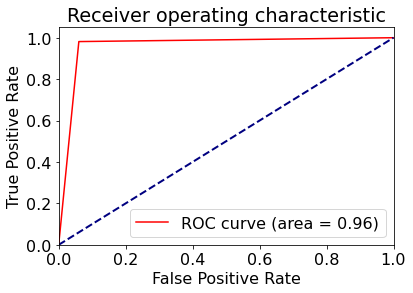

In [125]:
xgb_predict_test_th_2 = xgb_model_prob_pred_test_2[:,1] > xgb_best_th_2
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, xgb_predict_test_th_2, "")

**Just example to prove the point of how the threshold works**

In [126]:
(1.0-xgb_best_th_2)
xg_th_2 = round((1.0-xgb_best_th_2),3)
xg_th_2

0.982022462412715

0.982

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.28      0.98      0.44       375

    accuracy                           0.94     16000
   macro avg       0.64      0.96      0.70     16000
weighted avg       0.98      0.94      0.96     16000

[[14685   940]
 [    8   367]]
Accuracy: 0.94075
roc_auc_score: 0.9592533333333334
precision_score: 0.28079571537872994
recall_score: 0.9786666666666667
f1_score: 0.436385255648038
CM: FP 940
CM: FN 8
APS Cost =  13400


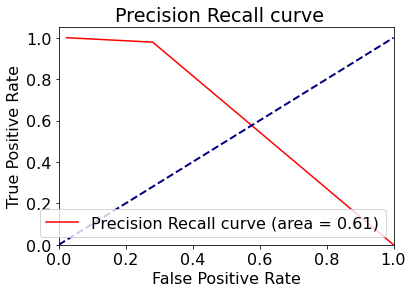

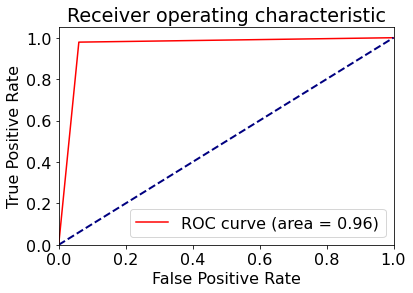

In [127]:
y_2 = xgb_model_prob_pred_test_2[:,0] < xg_th_2
model_evaluaiton(y_test, y_2, "")

-----

### df_train_5 (i.e. IR = 0.4)

In [128]:
X_train_5, y_train_5 = get_train_data(df_train_5)
xgb_best_model_5 = xgb_model(X_train_5, y_train_5)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.9min finished


**Evaluating on Testing-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     15625
           1       0.68      0.33      0.44       375

    accuracy                           0.98     16000
   macro avg       0.83      0.66      0.72     16000
weighted avg       0.98      0.98      0.98     16000

[[15568    57]
 [  252   123]]
Accuracy

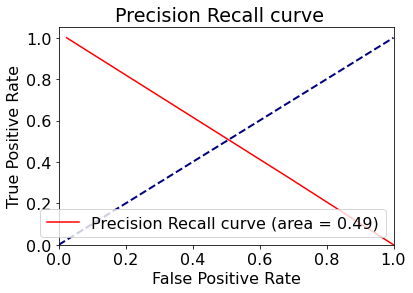

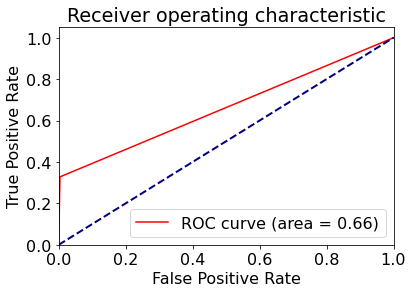

In [129]:
xgb_model_pred_test_5, xgb_model_prob_pred_test_5 = model_prediction(xgb_best_model_5, X_test)
model_evaluaiton(y_test, xgb_model_pred_test_5,"")

**Evaluate on Training-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     59000
         1.0       0.97      0.87      0.92      5000

    accuracy                           0.99     64000
   macro avg       0.98      0.94      0.96     64000
weighted avg       0.99      0.99      0.99     64000

[[58858   142]
 [  630  4370]]
Accuracy

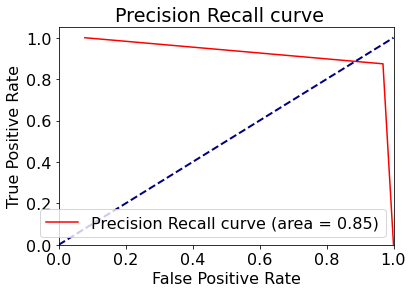

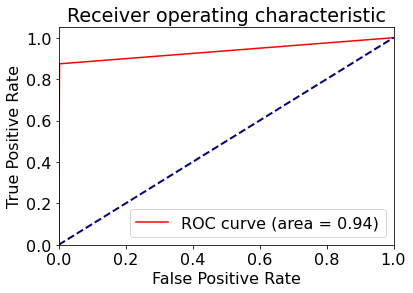

In [130]:
xgb_model_pred_train_5, xgb_model_prob_pred_train_5 = model_prediction(xgb_best_model_5, X_train_5)
model_evaluaiton(y_train_5, xgb_model_pred_train_5, "")

**Finding the threshold and then evaluate on testing data**
- xgb_model_prob_pred_test_5[:,1] : classifier probability's output for minority class

In [131]:
xgb_best_th_5 = find_cut_off(y_test, xgb_model_prob_pred_test_5[:,1])

100%|██████████| 6461/6461 [04:33<00:00, 23.61it/s]

Best threshold: 0.0212
Min cost: 13300.00


In [132]:
xgb_best_th_5

0.02124546

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.27      0.98      0.43       375

    accuracy                           0.94     16000
   macro avg       0.64      0.96      0.70     16000
weighted avg       0.98      0.94      0.95     16000

[[14645   980]
 [    7   368]]
Accuracy: 0.9383125
roc_auc_score: 0.9593066666666665
precision_score: 0.27299703264094954
recall_score: 0.9813333333333333
f1_score: 0.4271619268717353
CM: FP 980
CM: FN 7
APS Cost =  13300


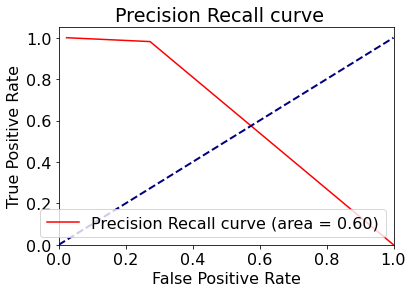

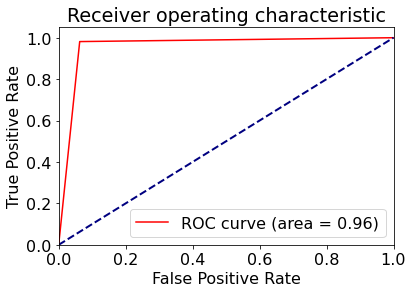

In [133]:
xgb_predict_test_th_5 = xgb_model_prob_pred_test_5[:,1] > xgb_best_th_5
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, xgb_predict_test_th_5, "")

**Just example to prove the point of how the threshold works**

In [134]:
(1.0-xgb_best_th_5)
xg_th_5 = round((1.0-xgb_best_th_5),3)
xg_th_5

0.9787545409053564

0.979

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     15625
           1       0.27      0.98      0.43       375

    accuracy                           0.94     16000
   macro avg       0.64      0.96      0.70     16000
weighted avg       0.98      0.94      0.95     16000

[[14643   982]
 [    7   368]]
Accuracy: 0.9381875
roc_auc_score: 0.9592426666666666
precision_score: 0.2725925925925926
recall_score: 0.9813333333333333
f1_score: 0.42666666666666664
CM: FP 982
CM: FN 7
APS Cost =  13320


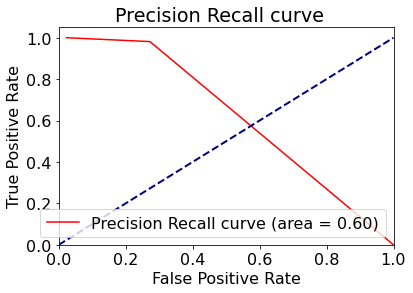

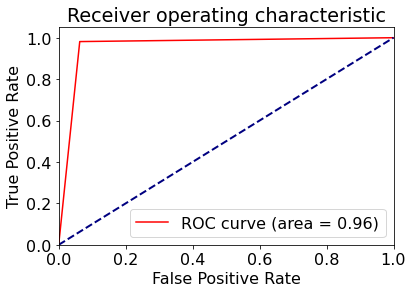

In [135]:
y_5 = xgb_model_prob_pred_test_5[:,0] < xg_th_5
model_evaluaiton(y_test, y_5, "")

----

### df_train_10 (i.e. IR = 0.6)

In [136]:
X_train_10, y_train_10 = get_train_data(df_train_10)
xgb_best_model_10 = xgb_model(X_train_10, y_train_10)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.0min finished


**Evaluating on Testing-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     15625
           1       0.48      0.14      0.21       375

    accuracy                           0.98     16000
   macro avg       0.73      0.57      0.60     16000
weighted avg       0.97      0.98      0.97     16000

[[15569    56]
 [  324    51]]
Accurac

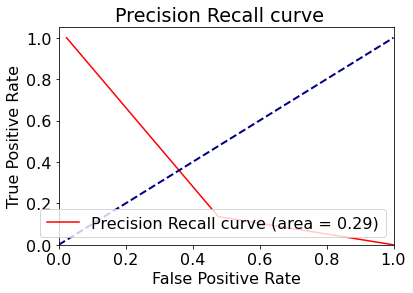

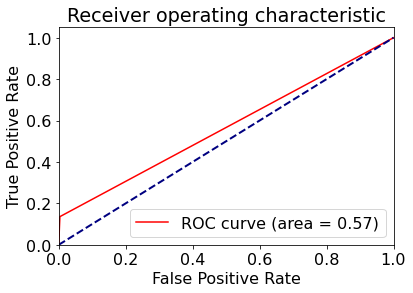

In [137]:
xgb_model_pred_test_10, xgb_model_prob_pred_test_10 = model_prediction(xgb_best_model_10, X_test)
model_evaluaiton(y_test, xgb_model_pred_test_10,"")

**Evaluate on Training-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     59000
         1.0       0.98      0.91      0.94     10000

    accuracy                           0.98     69000
   macro avg       0.98      0.95      0.97     69000
weighted avg       0.98      0.98      0.98     69000

[[58773   227]
 [  867  9133]]
Accurac

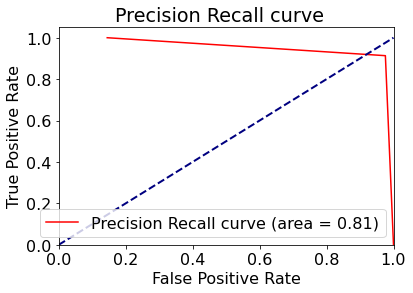

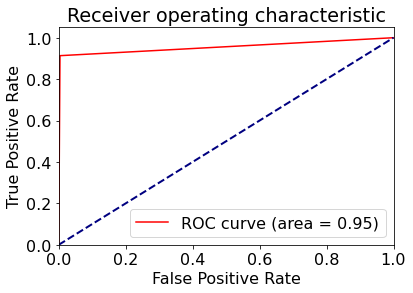

In [138]:
xgb_model_pred_train_10, xgb_model_prob_pred_train_10 = model_prediction(xgb_best_model_10, X_train_10)
model_evaluaiton(y_train_10, xgb_model_pred_train_10, "")

**Finding the threshold and then evaluate on testing data**
- xgb_model_prob_pred_test_10[:,1] : classifier probability's output for minority class

In [139]:
xgb_best_th_10 = find_cut_off(y_test, xgb_model_prob_pred_test_10[:,1])

100%|██████████| 1968/1968 [01:26<00:00, 22.80it/s]

Best threshold: 0.0301
Min cost: 15860.00


In [140]:
xgb_best_th_10

0.030075712

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     15625
           1       0.25      0.97      0.40       375

    accuracy                           0.93     16000
   macro avg       0.63      0.95      0.68     16000
weighted avg       0.98      0.93      0.95     16000

[[14539  1086]
 [   10   365]]
Accuracy: 0.9315
roc_auc_score: 0.9519146666666667
precision_score: 0.25155065472088217
recall_score: 0.9733333333333334
f1_score: 0.3997809419496167
CM: FP 1086
CM: FN 10
APS Cost =  15860


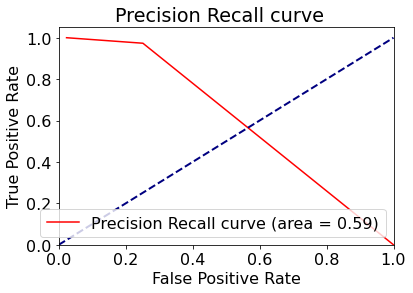

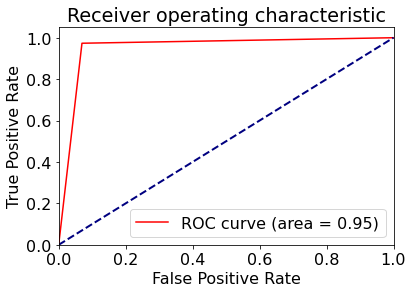

In [141]:
xgb_predict_test_th_10 = xgb_model_prob_pred_test_10[:,1] > xgb_best_th_10
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, xgb_predict_test_th_10, "")

**Just example to prove the point of how the threshold works**

In [142]:
(1.0-xgb_best_th_10)
xg_th_10 = round((1.0-xgb_best_th_10),3)
xg_th_10

0.9699242878705263

0.97

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     15625
           1       0.25      0.97      0.40       375

    accuracy                           0.93     16000
   macro avg       0.63      0.95      0.68     16000
weighted avg       0.98      0.93      0.95     16000

[[14537  1088]
 [   10   365]]
Accuracy: 0.931375
roc_auc_score: 0.9518506666666667
precision_score: 0.25120440467997246
recall_score: 0.9733333333333334
f1_score: 0.3993435448577681
CM: FP 1088
CM: FN 10
APS Cost =  15880


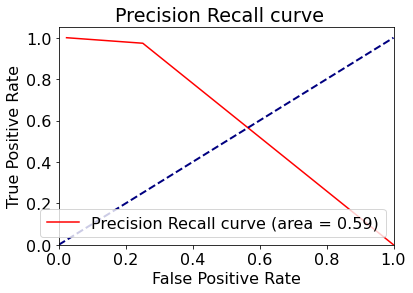

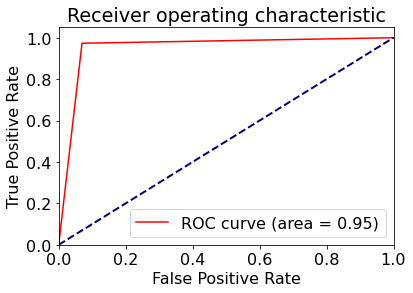

In [143]:
y_10 = xgb_model_prob_pred_test_10[:,0] < xg_th_10
model_evaluaiton(y_test, y_10, "")

-----

### df_train_18 (i.e. IR = 0.8)

In [144]:
X_train_18, y_train_18 = get_train_data(df_train_18)
xgb_best_model_18 = xgb_model(X_train_18, y_train_18)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.5min finished


**Evaluating on Testing-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     15625
           1       0.45      0.11      0.18       375

    accuracy                           0.98     16000
   macro avg       0.72      0.56      0.59     16000
weighted avg       0.97      0.98      0.97     16000

[[15573    52]
 [  332    43]]
Accurac

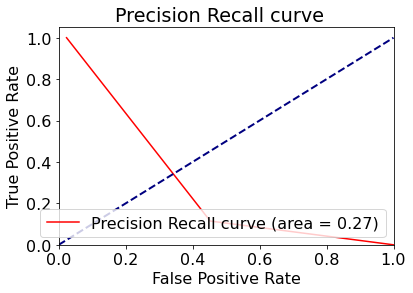

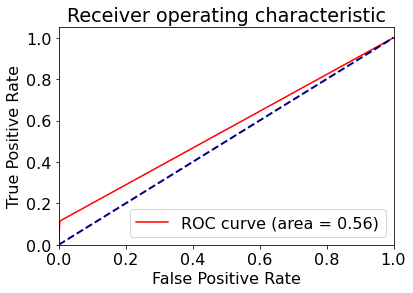

In [145]:
xgb_model_pred_test_18, xgb_model_prob_pred_test_18 = model_prediction(xgb_best_model_18, X_test)
model_evaluaiton(y_test, xgb_model_pred_test_18,"")

**Evaluate on Training-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     59000
         1.0       0.99      0.95      0.97     18000

    accuracy                           0.99     77000
   macro avg       0.99      0.97      0.98     77000
weighted avg       0.99      0.99      0.99     77000

[[58781   219]
 [  893 17107]]
Accurac

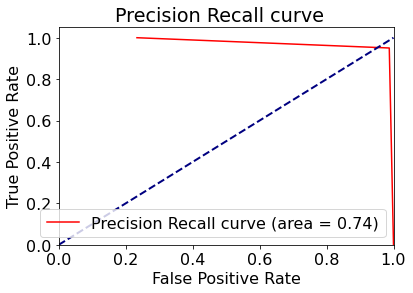

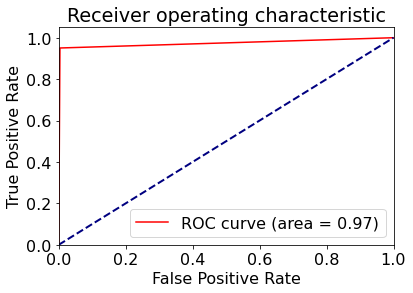

In [146]:
xgb_model_pred_train_18, xgb_model_prob_pred_train_18 = model_prediction(xgb_best_model_18, X_train_18)
model_evaluaiton(y_train_18, xgb_model_pred_train_18, "")

**Finding the threshold and then evaluate on testing data**
- xgb_model_prob_pred_test_18[:,1] : classifier probability's output for minority class

In [147]:
xgb_best_th_18 = find_cut_off(y_test, xgb_model_prob_pred_test_18[:,1])

100%|██████████| 2023/2023 [01:30<00:00, 22.47it/s]

Best threshold: 0.0251
Min cost: 15810.00


In [148]:
xgb_best_th_18

0.025081806

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     15625
           1       0.24      0.98      0.38       375

    accuracy                           0.93     16000
   macro avg       0.62      0.95      0.67     16000
weighted avg       0.98      0.93      0.95     16000

[[14444  1181]
 [    8   367]]
Accuracy: 0.9256875
roc_auc_score: 0.9515413333333334
precision_score: 0.23708010335917312
recall_score: 0.9786666666666667
f1_score: 0.38169526781071245
CM: FP 1181
CM: FN 8
APS Cost =  15810


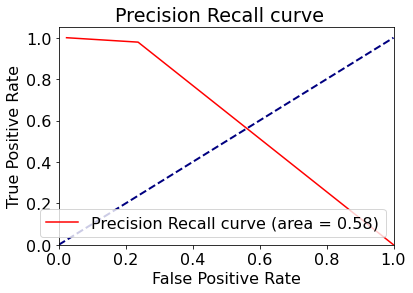

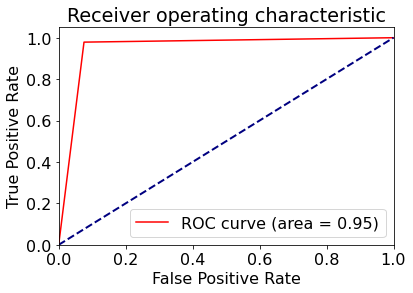

In [149]:
xgb_predict_test_th_18 = xgb_model_prob_pred_test_18[:,1] > xgb_best_th_18
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, xgb_predict_test_th_18, "")

**Just example to prove the point of how the threshold works**

In [150]:
(1.0-xgb_best_th_18)
xg_th_18 = round((1.0-xgb_best_th_18),3)
xg_th_18

0.9749181941151619

0.975

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     15625
           1       0.24      0.98      0.38       375

    accuracy                           0.93     16000
   macro avg       0.62      0.95      0.67     16000
weighted avg       0.98      0.93      0.95     16000

[[14443  1182]
 [    8   367]]
Accuracy: 0.925625
roc_auc_score: 0.9515093333333334
precision_score: 0.23692704970949
recall_score: 0.9786666666666667
f1_score: 0.3814968814968815
CM: FP 1182
CM: FN 8
APS Cost =  15820


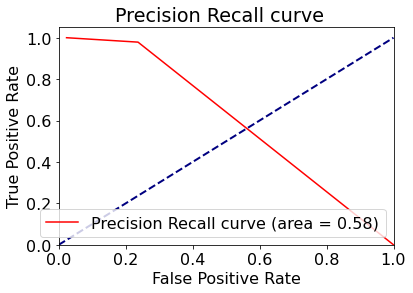

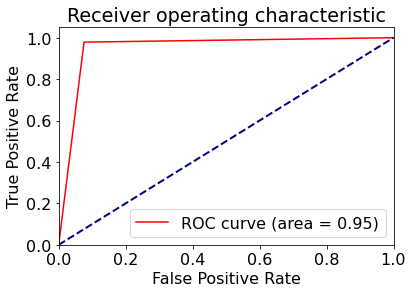

In [151]:
y_18 = xgb_model_prob_pred_test_18[:,0] < xg_th_18
model_evaluaiton(y_test, y_18, "")

-----

### df_train_59 (i.e. IR = 1.0)

In [152]:
X_train_59, y_train_59 = get_train_data(df_train_59)
xgb_best_model_59 = xgb_model(X_train_59, y_train_59)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  3.9min finished


**Evaluating on Testing-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     15625
           1       0.13      0.03      0.05       375

    accuracy                           0.97     16000
   macro avg       0.55      0.51      0.52     16000
weighted avg       0.96      0.97      0.96     16000

[[15549    76]
 [  364    11]]
Accuracy

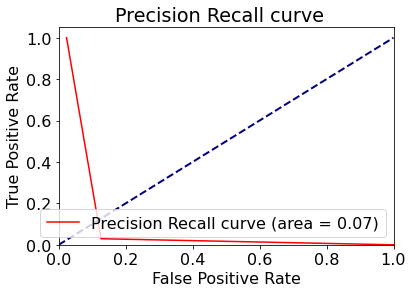

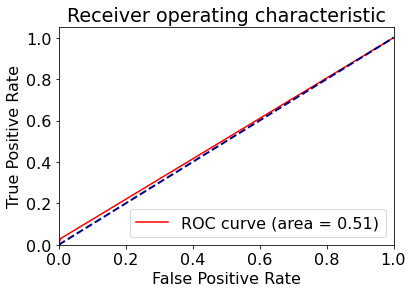

In [153]:
xgb_model_pred_test_59, xgb_model_prob_pred_test_59 = model_prediction(xgb_best_model_59, X_test)
model_evaluaiton(y_test, xgb_model_pred_test_59,"")

**Evaluate on Training-set**

Best estimator:  XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     59000
         1.0       0.99      0.98      0.99     59000

    accuracy                           0.99    118000
   macro avg       0.99      0.99      0.99    118000
weighted avg       0.99      0.99      0.99    118000

[[58697   303]
 [  977 58023]]
Accuracy

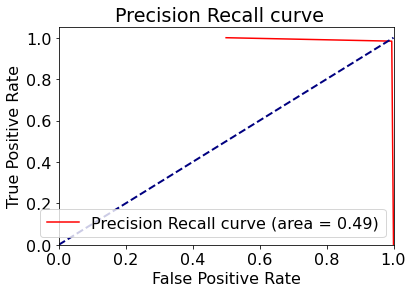

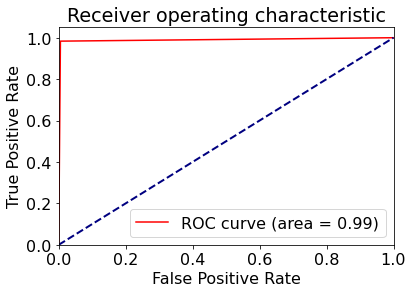

In [154]:
xgb_model_pred_train_59, xgb_model_prob_pred_train_59 = model_prediction(xgb_best_model_59, X_train_59)
model_evaluaiton(y_train_59, xgb_model_pred_train_59, "")

**Finding the threshold and then evaluate on testing data**
- xgb_model_prob_pred_test_59[:,1] : classifier probability's output for minority class

In [155]:
xgb_best_th_59 = find_cut_off(y_test, xgb_model_prob_pred_test_59[:,1])

100%|██████████| 454/454 [00:20<00:00, 22.14it/s]

Best threshold: 0.0902
Min cost: 17050.00


In [156]:
xgb_best_th_59

0.09018202

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     15625
           1       0.23      0.97      0.38       375

    accuracy                           0.92     16000
   macro avg       0.62      0.95      0.67     16000
weighted avg       0.98      0.92      0.95     16000

[[14420  1205]
 [   10   365]]
Accuracy: 0.9240625
roc_auc_score: 0.9481066666666668
precision_score: 0.23248407643312102
recall_score: 0.9733333333333334
f1_score: 0.37532133676092544
CM: FP 1205
CM: FN 10
APS Cost =  17050


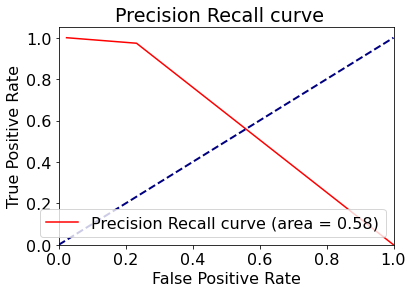

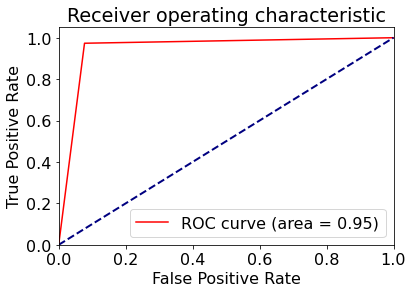

In [157]:
xgb_predict_test_th_59 = xgb_model_prob_pred_test_59[:,1] > xgb_best_th_59
#LR_predict_test_th = LR_pre_prob_test[:,1] > 0.34

model_evaluaiton(y_test, xgb_predict_test_th_59, "")

**Just example to prove the point of how the threshold works**

In [158]:
(1.0-xgb_best_th_59)
xg_th_59 = round((1.0-xgb_best_th_59),3)
xg_th_59

0.9098179787397385

0.91

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     15625
           1       0.23      0.97      0.37       375

    accuracy                           0.92     16000
   macro avg       0.62      0.95      0.67     16000
weighted avg       0.98      0.92      0.95     16000

[[14416  1209]
 [   10   365]]
Accuracy: 0.9238125
roc_auc_score: 0.9479786666666666
precision_score: 0.23189326556543838
recall_score: 0.9733333333333334
f1_score: 0.3745510518214469
CM: FP 1209
CM: FN 10
APS Cost =  17090


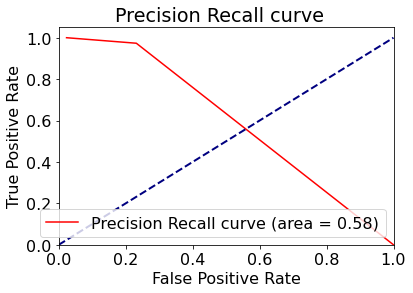

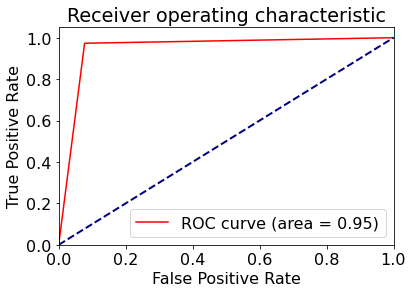

In [159]:
y_59 = xgb_model_prob_pred_test_59[:,0] < xg_th_59
model_evaluaiton(y_test, y_59, "")

----